<a href="https://colab.research.google.com/github/Lewis34cs/corona_audio/blob/main/covid_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project

#### COVID-19 Exploration in statistics and diagnosis via imaging and audio

>Flow of project:
- go into diagnosing COVID-19 using x-rays
- explain how while this is useful, it requires the patient to actually come in and get an x-ray, which can bring risk of infection to those in the building where x-ray imaging is done
- talk about coughing audio, how we can create spectrogram images from it to train neural networks to try and achieve a high recall/auc.

In [1]:
# We must run this in order for colab to be able to access our google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Allows us to see the type of GPU we are given

# Because we have Google Pro, we are given a better GPU to work with, which means
# we are able to do everything at a faster pace than those with no Google Pro subscription.
# We can verify this by taking a look at the GPU we are given below.

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jan 28 00:03:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Importing Libraries

In [3]:
#Setting seeds first in order to achieve better consistency in scoring
import numpy as np
import tensorflow as tf

np.random.seed(321)
tf.random.set_seed(321)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os, sys, glob, shutil
import datetime as dt

In [5]:
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
import time
from IPython.display import Image, display
from PIL import Image as Im
import cv2
import shutil
from google.colab import files

# tensorflow libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.applications import VGG19, InceptionV3, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_addons as tfa

In [6]:
import librosa.display as ldp
import IPython.display as ipd

In [7]:
# installing other libraries
!pip install split-folders
!pip install split-folders tqdm
!pip install pydub
!pip install soundfile
!pip install ffmpeg-python
!pip install zip_files

In [8]:
import splitfolders
from tqdm import tqdm
from pydub import AudioSegment
from pydub.playback import play
import ffmpeg
import soundfile as sf
import warnings

In [9]:
# Suppressing a specific warning from librosa
warnings.filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")
import librosa

In [10]:
plt.style.use('dark_background')

# PART 1

In [11]:
# Viewing where we are in the directory
os.path.abspath(os.curdir)

'/content'

## Obtaining COVID CXR Images via Kaggle API

In [12]:
# Hiding my key by having a variable store the info
API_key = files.upload()

Saving kaggle.json to kaggle.json


In [13]:
# Creating a hidden folder then copying my API key and putting it in that file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [14]:
# Permissions of 600 mean that I (the owner) have full read and write access to the 
# file, while no other user can access or edit the file
!chmod 600 ~/.kaggle/kaggle.json

In [15]:
# Downloading the zipped dataset via Kaggle's API
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 1.12G/1.14G [00:14<00:00, 90.2MB/s]
100% 1.14G/1.14G [00:14<00:00, 83.6MB/s]


In [16]:
# Unzipping the file and extracting to '/content' directory
from zipfile import ZipFile
f_name = "covid19-radiography-database.zip"
with ZipFile(f_name, 'r') as zipf:
      zipf.extractall()
      print('Done')

Done


In [17]:
# removing unnecessary files
!rm /content/covid19-radiography-database.zip

In [18]:
# Setting directory location to root directory
%cd ~
%cd ..

/root
/


### Unzipping folder containing CXR images

In [19]:
def folder_contents(source_folder=os.path.abspath(os.curdir)): # '/content/drive/My Drive'):
    """
    Definition:
    Displays the contents within a source folder.

    Parameter:
    source_folder: default = os.path.abspath(os.curdir) -- when a folder is set to
    this parameter, the function will display everything within that folder.

    Returns:
    Prints the address of the source_folder and displays the contents within.
    """

    print(f"Contents of {source_folder}:\n")
    display(sorted(os.listdir(source_folder)))

In [20]:
def time_count(start, end):
  """
  Definition:
  Simple function that prints how many seconds it took to run from the 'start'
  variable to the 'end' variable.

  Args:
  start: Required. Usually a time.time() variable at the beginning of a cell.
  end: Required. Usually a time.time() variable at the end of a cell.

  Returns:
  Prints the difference in time between the 'start' and 'end' variables.
  """
  
  print(f"Time to run cell: {int(end-start)} seconds")

In [21]:
# setting a variable called base_folder that contains the directory of where 
# our chest x-ray images are
base_folder = '/content/COVID-19 Radiography Database'

In [22]:
# Viewing the contents within our base_folder
folder_contents(base_folder)

Contents of /content/COVID-19 Radiography Database:



['COVID',
 'COVID.metadata.xlsx',
 'NORMAL',
 'NORMAL.metadata.xlsx',
 'README.md.txt',
 'Viral Pneumonia',
 'Viral Pneumonia.metadata.xlsx']

#### Identifying the number of images in our dataset

In [23]:
def num_items(folder, targets=['/COVID', '/NORMAL', '/Viral Pneumonia'], verbose=True):
  """
  Definition:
  Adds up the number of files within each target folder and prints out the target
  folder name along with the total number of items in the folder. Also prints 
  the folder's directory path.

  Args:
  folder: Required. A filepath containing the data you wish to count.
  targets: default = ['/COVID', '/NORMAL', '/Viral Pneumonia']. Specify the target
  folders you wish to see how many items are contained within each.

  Returns:
  Prints out directory path, target folder names, and total number of items
  within each folder. Returns the 'num_items' variable.
  """
  if verbose:

    num_items = 0
    # Printing the folder address we are targeting
    print(folder)
    # the target is each subfolder within our folder 
    # (the default is NORMAL and PNEUMONIA)
    for target in targets:
        # counts the number of images within each target
        num_in_target = len(os.listdir(folder+target))
        # add the total number of images for each folder
        num_items += num_in_target
        print(f"Number of items in {target}: {num_in_target}")
    print(f"Total number of items: {num_items}")
    return num_items
  
  else:
    num_items = 0
    for target in targets:
        # counts the number of images within each target
        num_in_target = len(os.listdir(folder+target))
        # add the total number of images for each folder
        num_items += num_in_target
    return num_items

In [24]:
total_image_number = num_items(base_folder)

/content/COVID-19 Radiography Database
Number of items in /COVID: 1200
Number of items in /NORMAL: 1341
Number of items in /Viral Pneumonia: 1345
Total number of items: 3886


### Splitting our images into train, test, and validation sets

In [25]:
#making a temporary folder to store our train, test, and validation folders
os.makedirs('/content/cxr_folders', exist_ok=True)

#### Temporary Folder Creation & Check

In [26]:
# Using the splitfolders library to split our images into train, test, and validation
# subfolders by our desired ratio, and placing these subfolders in a new directory

# source of how to run: https://github.com/jfilter/split-folders
run = 1
if run:
  splitfolders.ratio(input=base_folder, 
                    output='/content/cxr_folders', 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio order: train, val, test
else:
  print('Did not run')

Copying files: 3886 files [00:08, 435.51 files/s]


In [27]:
# Checking the contents within our target folder

def folder_check(root_dir, orig_dir=None, subfolders=['/train', '/test', '/val'], 
                 check=0):
  """
  Definition:
  This funcion works best if splitfolders library was used to split data into 
  ratioed folders. The 'root_dir' must contain the folders defined in the 
  'subfolders' list. Counts the number of items for each class within 
  each subfolder. Checks the number of images to the original folder (optional).

  Args:
  root_dir: Required. Address of newly created folder.
  orig_dir: default = None. Address of original folder where images originated from.
  subfolders: default = ['/train', '/test', '/val']. Subfolders within the root_dir
  that contain the images.
  check: default = 1.

  Returns:
  Prints the total image count for all subfolders. Optionally prints boolean value
  if the total image count is equal to the total count of the orig_dir.
  """
  count_images = 0
  
  for folder in subfolders:
    targets = os.listdir(root_dir + folder)
    count_images += num_items(folder=root_dir + folder + '/', targets=targets)
    print()
  if check:
    total_image_number = num_items(orig_dir)
    print(f"\nAre the image numbers equal?\n{total_image_number == count_images}")

  print(f"\nTotal image count: {count_images}")

In [28]:
root_dir = '/content/cxr_folders'
folder_check(root_dir, orig_dir=base_folder, check=1)

/content/cxr_folders/train/
Number of items in COVID: 840
Number of items in NORMAL: 938
Number of items in Viral Pneumonia: 941
Total number of items: 2719

/content/cxr_folders/test/
Number of items in COVID: 240
Number of items in NORMAL: 269
Number of items in Viral Pneumonia: 270
Total number of items: 779

/content/cxr_folders/val/
Number of items in COVID: 120
Number of items in NORMAL: 134
Number of items in Viral Pneumonia: 134
Total number of items: 388

/content/COVID-19 Radiography Database
Number of items in /COVID: 1200
Number of items in /NORMAL: 1341
Number of items in /Viral Pneumonia: 1345
Total number of items: 3886

Are the image numbers equal?
True

Total image count: 3886


In [29]:
def create_ttv(root_dir):
  """
  Definition:
  Appends the string of each address within the 'root_dir' variable to the list 
  'ttv_list', sorts them by ABC order, and returns the list.

  Args:
  root_dir: Required. Specify a directory that contains train, test, and validation
  folders.

  Returns:
  The address of each train, test, and validation folder within the specified
  directory.
  """

  # adds a '/' to the end of the string address of 'root_dir' if there is not
  # already one there.
  if root_dir[-1] != '/':
    root_dir = root_dir + '/'
  # creating an empty list to hold addresses
  ttv_list = []
  for folder in os.listdir(root_dir):
    # creating and adding the string of each address to 'ttv_list'
    ttv_list.append(root_dir + folder + '/')
  # Sorting the list alphabetically to capture the correct addresses for each variable
  ttv_list.sort()
  test_folder = ttv_list[0]
  train_folder = ttv_list[1]
  val_folder = ttv_list[2]
  # returning the variables that each contain an address 
  return train_folder, test_folder, val_folder

In [30]:
# Creating variables to hold our addresses for our train, test, and val folders
train_folder, test_folder, val_folder = create_ttv('/content/cxr_folders')

In [31]:
train_folder

'/content/cxr_folders/train/'

In [32]:
def batch_sizes(folder_list=[]):
  """
  Definition:
  Creates batch sizes for each folder by counting the total number of items in 
  each folder. Appends these numbers to a list "batch" and returns the list. 
  Works best with the create_ttv() function.

  Args:
  folder_list: default = []. Pass in a list of folder directories that contain
  items you wish to be counted for batch sizes. 

  Returns:
  A list containing the batch sizes for each folder that was passed in.

  """
  batch = []
  for folder in folder_list:
    targets = os.listdir(folder)
    batch.append(num_items(folder, verbose=0, targets=targets))
  return batch

In [33]:
TRAIN_BATCH_SIZE, TEST_BATCH_SIZE, VAL_BATCH_SIZE = batch_sizes([train_folder, 
                                                                 test_folder, 
                                                                 val_folder])
print(TRAIN_BATCH_SIZE, TEST_BATCH_SIZE, VAL_BATCH_SIZE)
print(TRAIN_BATCH_SIZE + TEST_BATCH_SIZE + VAL_BATCH_SIZE)

2719 779 388
3886


#### Setting up ImageDataGenerators

In [34]:
train_folder

'/content/cxr_folders/train/'

In [35]:
# Defining our image size
IMG_SIZE = (128, 128)

# Creating ImageDataGenerators for train and test/val
train_datagen = ImageDataGenerator(rescale=1./255)
test_val_datagen = ImageDataGenerator(rescale=1./255)

In [36]:
# Having each IDG using flow_from_directory by our defined batch sizes to create
# iterators that will spit out the entire set of data.
dummy_train_generator = train_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=TRAIN_BATCH_SIZE,
                                                   class_mode='categorical')

dummy_test_generator = test_val_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=TEST_BATCH_SIZE,
                                                     class_mode='categorical')

dummy_val_generator = test_val_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=VAL_BATCH_SIZE,
                                                    class_mode='categorical')

Found 2719 images belonging to 3 classes.
Found 779 images belonging to 3 classes.
Found 388 images belonging to 3 classes.


In [37]:
# Viewing the classes within our iterator
dummy_train_generator.class_indices

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

In [38]:
start = time.time()
# Creating X and y values for dummy train, test, and validation sets
X_train, y_train = next(dummy_train_generator)
X_test, y_test = next(dummy_test_generator)
X_val, y_val = next(dummy_val_generator)

end = time.time()
time_count(start, end)

Time to run cell: 43 seconds


In [39]:
# Creating our INPUT_SHAPE variable that we will feed into our dummy classifier
INPUT_SHAPE = dummy_train_generator.image_shape 
print(INPUT_SHAPE)

(128, 128, 3)


In [40]:
def random_image(X, y, verbose=0):
  """
  Definition:
  Selects a random number (i) within the range of the length of X. Then prints 
  the class label associated with that random number (i) along with the image
  associated with the specific X[i] array.

  Args:
  X: an np.array
  y: labels associated with the np.array

  Returns:
  Prints the class along with the y label, and displays the randomly selected image.
  """

  # Getting a random number within the range of our X variable
  i = np.random.choice(range(len(X)))
  # Determining what the label is and printing appropriate class
  if verbose:

    if y[i] == 0:
      print(f"COVID-19 : Class {y[i]}")
    elif y[i] == 1:
      print(f"NORMAL : Class {y[i]}")
    else:
      print(f"Viral Pneumonia : Class {y[i]}")
  else:
    if y[i] == 0:
      print(f"Class {y[i]}")
    elif y[i] == 1:
      print(f"Class {y[i]}")
    else:
      print(f"Class {y[i]}")
  # Displaying the image
  display(array_to_img(X[i]))

NORMAL : Class 1


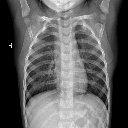

In [41]:
random_image(X_train, np.argmax(y_train, axis=1), verbose=1)

#### Baseline Model

In [42]:
# Creating and fitting our dummy classifier
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)

# Creating our y_pred variable
y_pred = dummy.predict(X_test)

# We need to one-hot encode our classes from our generated labels in order for
# The confusion matrix to be able to digest any of it
y_pred = np.argmax(y_pred, axis=1)
y_test_ohe = np.argmax(y_test, axis=1)

              precision    recall  f1-score   support

           0       0.32      0.64      0.42       240
           1       0.36      0.26      0.30       269
           2       0.38      0.14      0.21       270

    accuracy                           0.34       779
   macro avg       0.35      0.35      0.31       779
weighted avg       0.35      0.34      0.31       779



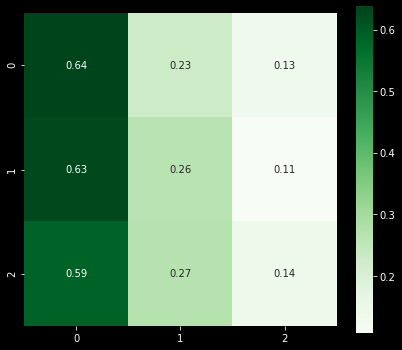

In [43]:
#Printing classification report and plotting confusion matrix
print(metrics.classification_report(y_test_ohe, y_pred));

plt.figure(figsize=(7, 6))
cm = metrics.confusion_matrix(y_test_ohe, y_pred, labels = [0, 1, 2], 
                              normalize='true')
sns.heatmap(cm, cmap="Greens", annot=True, square=True)
plt.show()

We built a baseline dummy classifier model that has an accuracy of 33%, and it tends to guess for the class == 0, which is our Covid class.

Since our dataset is relatively balanced in terms of classes, we expect to see the accuracy be around 33%.

In [44]:
# Creating generators for our model

train_generator = train_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=32,
                                                   class_mode='categorical')

test_generator = test_val_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=32,
                                                     class_mode='categorical', 
                                                     shuffle=False)

val_generator = test_val_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 2719 images belonging to 3 classes.
Found 779 images belonging to 3 classes.
Found 388 images belonging to 3 classes.


#### Viewing our Class Weights

In [45]:
def make_class_weights(train_gen, cls_weight='balanced', verbose=1):#, classification='binary'):
  # FIX THIS AREA
  """
  Definition:
  Creates a variable called 'class_weights' that is a list containing the weights
  for each class in the training generator. This list is converted into a dictionary
  and returned.

  Args:
  train_gen: Required. The training generator.
  cls_weight: default = 'balanced'. If ‘balanced’, class weights will be given 
  by n_samples / (n_classes * np.bincount(y)). If a dictionary is given, keys 
  are classes and values are corresponding class weights. If None is given, the 
  class weights will be uniform.
  verbose: default = 1. If verbose is true, the dictionary will also be printed.
  
  Returns:
  A dictionary containing the class weights
  """
  cwd = {}
  class_weights_list = class_weight.compute_class_weight(cls_weight,
                                            np.unique(train_gen.classes), 
                                            train_gen.classes)
  for cls in np.unique(train_gen.classes):
    cwd[cls] = class_weights_list[cls]

  if verbose:
    print(cwd)
  return cwd

In [46]:
class_weights_dict = make_class_weights(train_generator)

{0: 1.078968253968254, 1: 0.9662402274342573, 2: 0.963159759121502}


### Creating CNN Model

In [47]:
def create_basic_cnn(shape='',
                     metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall'), 
                              tf.keras.metrics.AUC(name='auc')]):
  """
  Definition:
  Creates a basic cnn model consisting of three layers and an output layer.

  Args:
  shape: this function requires an input shape in order for the model to be created.

  Returns:
  Returns a compiled model.
  """
  # We are requiring an input shape since we print the model.summary() at the 
  # end of the function
  if len(shape) < 1:
    print('Please define input shape!')
  else:
    # Input layer
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=shape))
    model.add(MaxPooling2D((2, 2)))

    # Second layer
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
      
    # Third layer
    model.add(Flatten())
    model.add(layers.Dense(128, activation='relu'))
      
    # Output layer
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    print(model.summary())
    return model

In [48]:
basic_model = create_basic_cnn(shape=INPUT_SHAPE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7372928   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [52]:
def plot_history(history, metric_list=['acc', 'loss', 'precision', 'recall', 'auc']):
  """
  Definition:
  Creates a dataframe with a model.history variable. Then plots columns within the 
  dataframe if the column contains a metric within the metric list.

  Args:
  history: requires a model.history variable.
  metric_list: default = ['loss', 'acc']. Based on the metric's used in the model's 
  compiled metrics. 

  Returns:
  plots the columns that contain the metric within the metric list
  """
  # creating a dataframe of the model.history variable
  history_df = pd.DataFrame(history.history)

  with plt.style.context('seaborn'):    
    for metric in metric_list:
      history_df[[col for col in history_df.columns if metric in col]].plot(figsize=(8, 4), 
                                                                            marker='o')

      # Setting the title for each plot to be be the focused metric
      plt.title(metric.title())
      plt.grid(True)
      #sets the vertical range to [0-1]
      plt.gca().set_ylim(0, 1)
    plt.show()

In [53]:
def class_report_gen(model,test_gen, class_indices, cmap='Reds'):
  """
  Definition:
  Prints out a classification report by predicting y_pred using model.predict() 
  and plots a heatmap of a confusion matrix using seaborn's heatmap() function. 

  Args:
  model: Requires a model.
  X_test: Requires a test set of features.
  y_test: Requires a test set of labels.
  class_indices: default = train_set_full.class_indices. Pass through a dictionary
  that defines the classes. Must match up with the y_test labels.

  Returns:
  Prints out a classification report and a confusion matrix.  
  """
    
  # creating a title using the class_indices.items()
  title = ''
  for key, val in class_indices.items():
        title += key + ' = ' + str(val) + '    '
    
  
  # Determining the number of classes
  limit = len(np.unique(test_gen.classes))
  if limit > 2:   
    # defining our prediction for multiple classification
    y_pred = model.predict(test_gen)
    y_pred = np.argmax(y_pred, axis=1)
  else:
    # defining our predicition for binary classification
    y_pred = model.predict(test_gen)
    y_pred = np.round(y_pred)

  # Printing a classification report to see accuracy, recall, precision, f1-score
  dashes = '---'*19
  print(dashes)  
  print('                  Classification Report\n')
  print(metrics.classification_report(test_gen.classes, y_pred))
  print(dashes)
    

  # plots a normalized confusion matrix
  plt.figure(figsize=(7,6))
  conf_mat = metrics.confusion_matrix(test_gen.classes, y_pred, normalize='true')
  ax = sns.heatmap(conf_mat, cmap=cmap, annot=True, square=True)
  ax.set(xlabel='Predicted Class', ylabel='True Class')
  ax.set_ylim(limit, 0)
  ax.set(title=title)
  plt.show()

In [54]:
def fit_plot_report_gen(model, train_gen, test_gen, val_gen,
                    epochs=10, batch_size=32, plot_hist=1, class_weights=None):
  """
  Definition:
  Fits a passed in model saved in a variable 'history'. Then activates the 
  class_report function which returns a classification report and a confusion
  matrix. Finally, plots the history using the plot_history() function.

  Args:
  model: Requires a model.
  X_train: Requires a train set of features.
  y_train: Requires a train set of labels.
  X_val: Requires a validation set of features.
  y_val: Requires a validation set of labels.
  X_test: Requires a test set of features.
  y_test: Requires a test set of labels.
  generator: Specify a generator to augment training data, this 
  variable will use the .flow() function to gather data from X_train and y_train 
  to augment the training data. 
  epochs: default = 10. Defines the number of passes the ML algorithm will complete.
  batch_size: default = 32. Defines the number of training examples utilized in
  one iteration before updating internal parameters.
  plot_hist: default = 1. Defines whether or not the plot_history() function will
  be executed. 
  class_weights: default = None. Pass in a dictionary containing the class weights, 
  where the keys are the classes and the values are the weights.

  Returns:
  history, prints classification report, confusion matrix, and plots history metrics.
  """
  start = time.time()
  history = model.fit(train_gen, batch_size=batch_size,  
                      validation_data=val_gen, epochs=epochs, 
                      class_weight=class_weights)
  
  # Identifying the number of classes
  class_indices = train_gen.class_indices
  class_report_gen(model, test_gen, class_indices=class_indices)
    
  if plot_hist:
      plot_history(history) 

  dashes = '---'*20
  print(dashes)
  eval_scores = model.evaluate(test_gen)
  metric_list=['loss', 'accuracy', 'precision', 'recall', 'auc']
  for i, score in enumerate(eval_scores):
    print(f"{metric_list[i]} score: {score}")
  print()
  end = time.time()
  time_count(start, end)
  return history

Epoch 1/5
85/85 [==============================] - 39s 406ms/step - loss: 1.0929 - acc: 0.6608 - precision: 0.7164 - recall: 0.4911 - auc: 0.8029 - val_loss: 0.1728 - val_acc: 0.9330 - val_precision: 0.9352 - val_recall: 0.9304 - val_auc: 0.9925
Epoch 2/5
85/85 [==============================] - 33s 392ms/step - loss: 0.1546 - acc: 0.9382 - precision: 0.9424 - recall: 0.9366 - auc: 0.9931 - val_loss: 0.1034 - val_acc: 0.9691 - val_precision: 0.9690 - val_recall: 0.9665 - val_auc: 0.9964
Epoch 3/5
85/85 [==============================] - 33s 389ms/step - loss: 0.1246 - acc: 0.9584 - precision: 0.9601 - recall: 0.9566 - auc: 0.9944 - val_loss: 0.0990 - val_acc: 0.9716 - val_precision: 0.9742 - val_recall: 0.9716 - val_auc: 0.9965
Epoch 4/5
85/85 [==============================] - 33s 389ms/step - loss: 0.0770 - acc: 0.9721 - precision: 0.9746 - recall: 0.9721 - auc: 0.9983 - val_loss: 0.1038 - val_acc: 0.9742 - val_precision: 0.9742 - val_recall: 0.9716 - val_auc: 0.9938
Epoch 5/5
85/85 

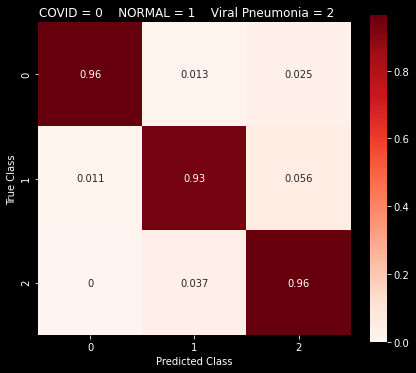

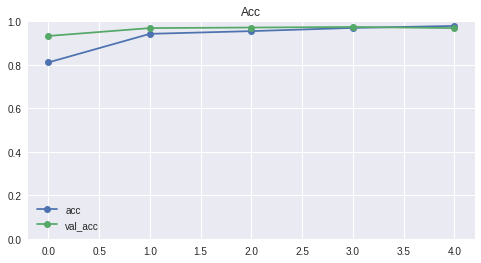

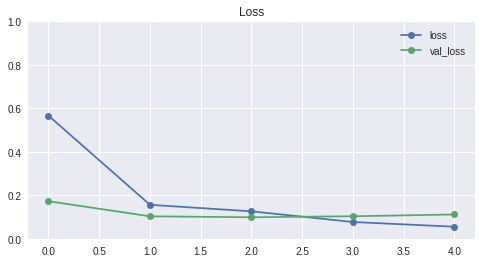

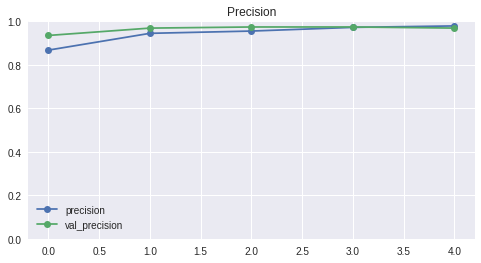

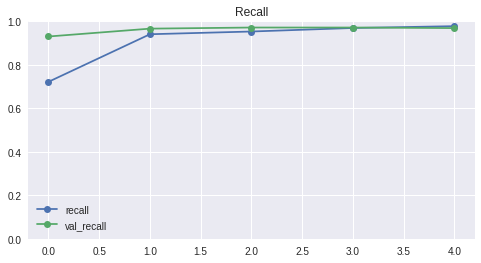

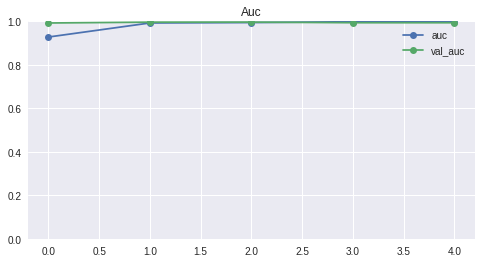

------------------------------------------------------------
25/25 [==============================] - 8s 338ms/step - loss: 0.1707 - acc: 0.9525 - precision: 0.9537 - recall: 0.9512 - auc: 0.9897
loss score: 0.17067119479179382
accuracy score: 0.9525032043457031
precision score: 0.953667938709259
recall score: 0.9512194991111755
auc score: 0.9896501898765564

Time to run cell: 189 seconds


In [55]:
hist1 = fit_plot_report_gen(basic_model, train_generator, test_generator, val_generator, 
                class_weights=class_weights_dict, epochs=5, batch_size=32)

### CLAHE Information & Examples

link for info on cv2.createCLAHE():
 - https://docs.opencv.org/master/d6/dc7/group__imgproc__hist.html#gad689d2607b7b3889453804f414ab1018

In [56]:
img = cv2.imread('/content/cxr_folders/train/COVID/COVID (1).png', 0)
img.shape

(256, 256)

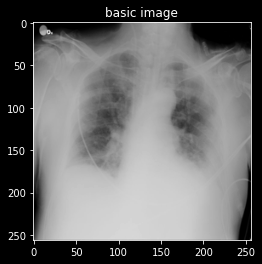

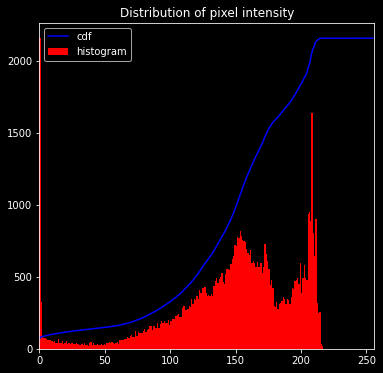

In [57]:
# Plotting an image to view, along with distribution of pixel intensity

plt.title('basic image')
plt.imshow(img, cmap='gray')
hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.figure(figsize=(6, 6))
plt.title('Distribution of pixel intensity')
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()


The next steps would be:
 - create preprocessed CLAHE images of each image in each train, test, and val folders 
 - place those pictures into the respective new class subfolders

### Creating CLAHE preprocessed images and placing them into new directory

In [58]:
base_folder = '/content/COVID-19 Radiography Database/'
new_folder = '/content/clahe_radio/'

def clahe_preprocessing(root_dir, new_dir):
  """
  Definition:
  from a specified directory 'root_dir', the function will loop through each
  subfolder and apply a clahe mask to each image and save that modified image in
  the 'new_dir' address.

  Args:
  root_dir: Required. The address of the directory that contains the subfolders
  holding the images.
  new_dir: Required. The directory where the modified images will be saved. This
  can be a directory that does not exist yet.

  Returns:
  Prints the time it took to run the function.
  """
  start = time.time()
  # creating our clahe mask to aply to images
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

  # Appending a '/' to the root_dir string if there is not already one
  if root_dir[-1] != '/':
    root_dir = root_dir + '/'

  # Looping through the subfolders in the root_dir
  for folder in os.listdir(root_dir):
    # If the end portion of an item within the folder contains something 
    # (eg: .png, .xlsx, .txt, etc.) the function will ignore it and continue;
    # it is only looking for subfolders to loop through.
    if os.path.splitext(folder)[-1].lower():
      continue

    # applying the clahe mask and saving the updated image to the new folder
    for image in os.listdir(root_dir + folder):
      img = cv2.imread(root_dir + folder + '/' + image, 0)
      cl_img = clahe.apply(img)
      os.makedirs(new_dir + folder, exist_ok=True)
      cv2.imwrite(new_dir + folder + '/' + image, cl_img)

  end = time.time()
  time_count(start, end)

In [59]:
clahe_preprocessing(base_folder, new_folder)

Time to run cell: 77 seconds


In [60]:
orig_img = cv2.imread('/content/COVID-19 Radiography Database/COVID/COVID (1).png')
clahe_img = cv2.imread('/content/clahe_radio/COVID/COVID (1).png')

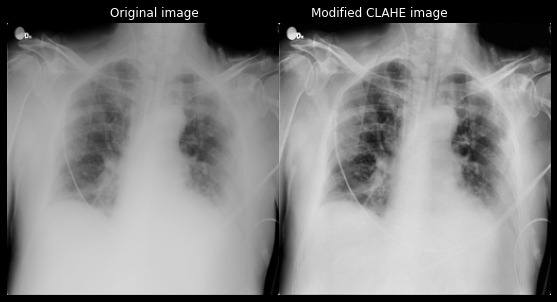

In [61]:
# Comparing original image (left) to CLAHE applied image (right)
res = np.hstack((orig_img,clahe_img))
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.imshow(res, cmap='gray')
plt.title('Original image                             Modified CLAHE image')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.show()

We can definitely see more of the infiltrate in the lung areas of the chest x-ray. These infiltrate areas of the lung can determine whether or not a person has Pneumonia. As far as what radiologists look for in COVID-19 x-ray images, I would have to research further to find an answer. For now, let's see if the model can make better predictions by training on our preprocessed images.

In [62]:
# Splitting our preprocess image folder into train, test, and validation subfolders
# in a new directory
run=1
if run:
  splitfolders.ratio(input='/content/clahe_radio', 
                    output='/content/clahe_ttv', 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio of data sharing for
                                                    # train, test, val folders

Copying files: 3886 files [00:05, 653.37 files/s]


In [63]:
folder_check('/content/clahe_ttv', check=0)

/content/clahe_ttv/train/
Number of items in COVID: 840
Number of items in NORMAL: 938
Number of items in Viral Pneumonia: 941
Total number of items: 2719

/content/clahe_ttv/test/
Number of items in COVID: 240
Number of items in NORMAL: 269
Number of items in Viral Pneumonia: 270
Total number of items: 779

/content/clahe_ttv/val/
Number of items in COVID: 120
Number of items in NORMAL: 134
Number of items in Viral Pneumonia: 134
Total number of items: 388


Total image count: 3886


### Modeling with CLAHE preprocessed images

Defining new folders for our preprocessed chest x-ray images

In [64]:
train_folder, test_folder, val_folder = create_ttv('/content/clahe_ttv')

In [65]:
train_folder

'/content/clahe_ttv/train/'

Defining image sizes for our preprocessed chest x-ray images

In [66]:
# Still the same size as our previous model
IMG_SIZE = (128, 128)

In [67]:
# We are still using the same imagedatagenerator as before to normalize our data,
# the 'train_datagen and test_val_datagen'
train_clahe_datagen = ImageDataGenerator(rescale=1./255)
                                         #width_shift_range=0.1, 
                                         #height_shift_range=0.1,
                                         #zoom_range=0.1, 
                                         #rotation_range=0.2)

test_val_clahe_datagen = ImageDataGenerator(rescale=1./255)

cl_train_generator = train_clahe_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=32,
                                                   class_mode='categorical')

cl_test_generator = test_val_clahe_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=32,
                                                     class_mode='categorical', 
                                                     shuffle=False)

cl_val_generator = test_val_clahe_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 2719 images belonging to 3 classes.
Found 779 images belonging to 3 classes.
Found 388 images belonging to 3 classes.


In [68]:
INPUT_SHAPE = cl_train_generator.image_shape
print(INPUT_SHAPE)

(128, 128, 3)


In [69]:
class_weights_dict = make_class_weights(cl_train_generator)

{0: 1.078968253968254, 1: 0.9662402274342573, 2: 0.963159759121502}


In [70]:
basic_prep_cnn = create_basic_cnn(shape=INPUT_SHAPE)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

Epoch 1/5
85/85 [==============================] - 23s 264ms/step - loss: 1.1448 - acc: 0.6937 - precision: 0.8704 - recall: 0.7848 - auc: 0.9365 - val_loss: 0.1321 - val_acc: 0.9510 - val_precision: 0.9560 - val_recall: 0.9510 - val_auc: 0.9936
Epoch 2/5
85/85 [==============================] - 22s 258ms/step - loss: 0.1298 - acc: 0.9499 - precision: 0.9521 - recall: 0.9448 - auc: 0.9946 - val_loss: 0.1063 - val_acc: 0.9613 - val_precision: 0.9611 - val_recall: 0.9562 - val_auc: 0.9965
Epoch 3/5
85/85 [==============================] - 22s 255ms/step - loss: 0.0976 - acc: 0.9677 - precision: 0.9694 - recall: 0.9643 - auc: 0.9969 - val_loss: 0.0989 - val_acc: 0.9716 - val_precision: 0.9742 - val_recall: 0.9716 - val_auc: 0.9954
Epoch 4/5
85/85 [==============================] - 22s 257ms/step - loss: 0.0543 - acc: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9991 - val_loss: 0.1096 - val_acc: 0.9665 - val_precision: 0.9665 - val_recall: 0.9665 - val_auc: 0.9950
Epoch 5/5
85/85 

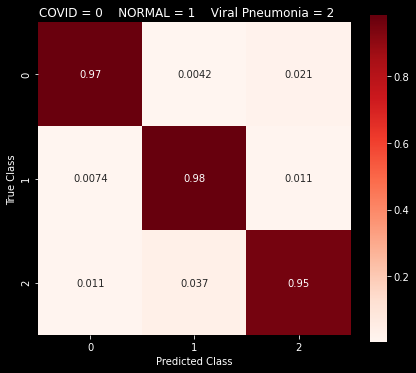

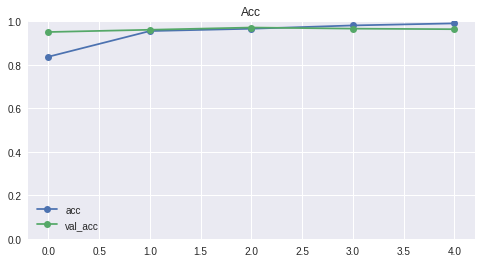

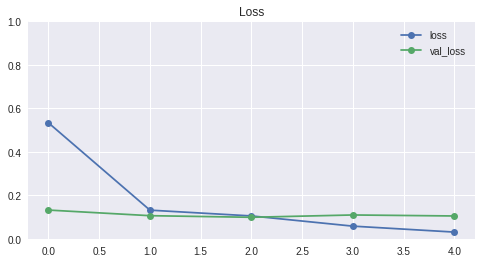

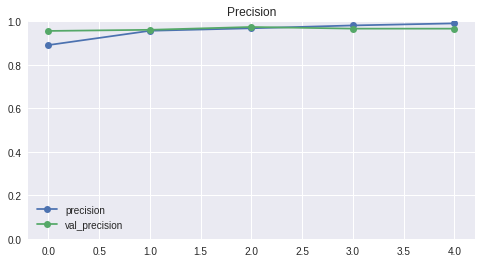

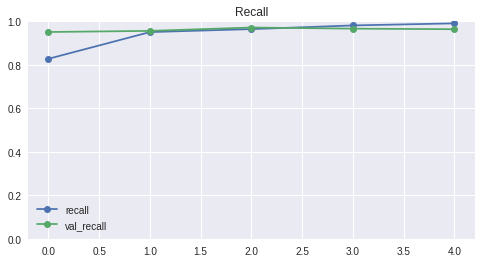

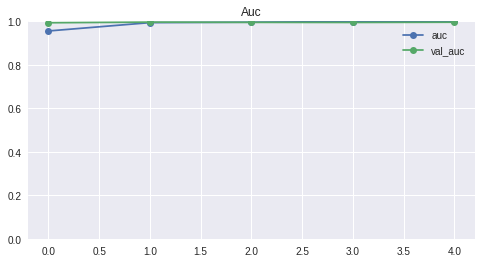

------------------------------------------------------------
25/25 [==============================] - 6s 226ms/step - loss: 0.1219 - acc: 0.9692 - precision: 0.9692 - recall: 0.9679 - auc: 0.9940
loss score: 0.1218811571598053
accuracy score: 0.9691912531852722
precision score: 0.9691516757011414
recall score: 0.9679075479507446
auc score: 0.9939848184585571

Time to run cell: 122 seconds


In [71]:
preprocessed_hist = fit_plot_report_gen(basic_prep_cnn, cl_train_generator, 
                                        cl_test_generator, cl_val_generator, 
                                        epochs=5, batch_size=32,
                                        class_weights=class_weights_dict)

# PART 2

While using x-rays to diagnose patients with COVID has proven to be successful with the model we've created, the process of each person getting an x-ray to determine if they have COVID can be costly. Furthermore, we wouldn't want someone with COVID to come into a facility and expose healthy people to the virus. So for this next part, we are going to explore the possiblities of using cough audio from healthy and COVID infected individuals and see if we can create a model that can accurately diagnose those with COVID. 

## Obtaining Virufy audio data

Finding the audio data proved to be more time consuming than finding chest x-ray data or the CDC dataset. 

In [72]:
# change the zipped_folder variable to match your filepath to access data
start = time.time()
zipped_folder = '/content/drive/MyDrive/virufy_data-main.zip'

fname = zipped_folder.split('/')[-1]

# Copying and unzipping the targeted file
!cp "{zipped_folder}" .
!unzip -q "{fname}" 
!rm "{fname}"
end = time.time()
time_count(start, end)

Time to run cell: 0 seconds


In [73]:
# Folder containing our segmented audio files
audio_base_folder = '/virufy_data-main/clinical/segmented/'

In [74]:
# Viewing subfolders in our audio_base_folder
folder_contents(audio_base_folder)

Contents of /virufy_data-main/clinical/segmented/:



['neg', 'pos']

In [75]:
# Counting the number of files in each subfolder
num_items(audio_base_folder, targets=['neg', 'pos'])

/virufy_data-main/clinical/segmented/
Number of items in neg: 73
Number of items in pos: 48
Total number of items: 121


121

In [76]:
start = time.time()

#Creating an empty dictionary to hold the duration for each file
audio_dict = {}
for folder in os.listdir(audio_base_folder):
  for mp3 in os.listdir(audio_base_folder + folder):
    signal, sr = librosa.load(audio_base_folder + folder + '/' + mp3)
    audio_dict[mp3] = librosa.get_duration(signal, sr)
    
end = time.time()
time_count(start, end)

Time to run cell: 48 seconds


In [77]:
# Viewing the mean, std, min, max, etc of the duration of our virufy audio
pd.Series(audio_dict.values()).describe()

count    121.000000
mean       1.599895
std        0.000029
min        1.599864
25%        1.599864
50%        1.599909
75%        1.599909
max        1.599955
dtype: float64

We see that the virufy audio data we have is all the same length (approx. 1.6 secs in length). This is good; we want to make sure our audio is the same length, otherwise the frequencies in the spectrograms we create will vary in size and duration in our images.

### Examining dataframe that came with the audio files

In [78]:
virufy_df = pd.read_csv('/virufy_data-main/clinical/labels.csv')

In [79]:
virufy_df.head()

,date,corona_test,age,gender,medical_history,smoker,patient_reported_symptoms,cough_filename
0,4/21,negative,53,male,"none,",yes,"none,",neg-0421-083-cough-m-53.mp3
1,4/21,positive,50,male,"Congestive heart failure,",no,"Shortness of breath,",pos-0421-084-cough-m-50.mp3
2,4/21,negative,43,male,"none,",no,"Sore throat,",neg-0421-085-cough-m-43.mp3
3,4/21,positive,65,male,"Asthma or chronic lung disease,",no,"Shortness of breath,New or worsening cough,",pos-0421-086-cough-m-65.mp3
4,4/21,positive,40,female,"none,",no,"Sore throat,Loss of taste,Loss of smell,",pos-0421-087-cough-f-40.mp3


In [80]:
virufy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   date                       16 non-null     object
 1   corona_test                16 non-null     object
 2   age                        16 non-null     int64 
 3   gender                     16 non-null     object
 4   medical_history            16 non-null     object
 5   smoker                     16 non-null     object
 6   patient_reported_symptoms  16 non-null     object
 7   cough_filename             16 non-null     object
dtypes: int64(1), object(7)
memory usage: 1.1+ KB


Note that our dataframe has 16 patients. While we have more audio data because the data was segmented, we should find more audio data if we want to train a model without worrying about overfitting to our small sample size.

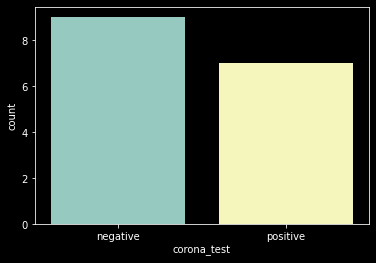

In [81]:
sns.countplot(x='corona_test', data=virufy_df)
plt.show()

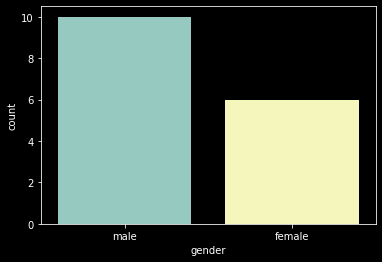

In [82]:
sns.countplot(x='gender', data=virufy_df)

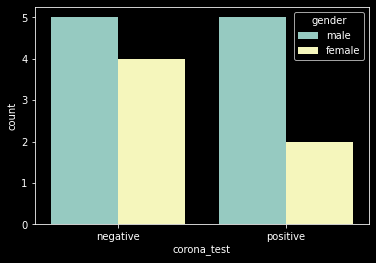

In [83]:
sns.countplot(x='corona_test', hue='gender', data=virufy_df)

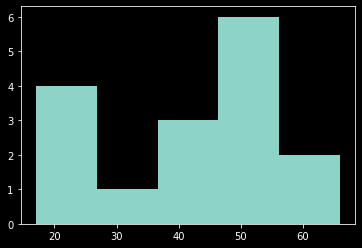

In [84]:
plt.hist(x='age', data=virufy_df, bins='auto')
plt.show()

In [85]:
virufy_df['medical_history'].value_counts()

none,                              12
Diabetes with complications,        2
Asthma or chronic lung disease,     1
Congestive heart failure,           1
Name: medical_history, dtype: int64

In [86]:
virufy_df['patient_reported_symptoms'].value_counts()

none,                                                                                                             6
Shortness of breath,New or worsening cough,                                                                       2
New or worsening cough,                                                                                           2
Sore throat,                                                                                                      1
Shortness of breath,                                                                                              1
Fever, chills, or sweating,New or worsening cough,Sore throat,                                                    1
Fever, chills, or sweating,Shortness of breath,New or worsening cough,Sore throat,Loss of taste,Loss of smell,    1
Sore throat,Loss of taste,Loss of smell,                                                                          1
Shortness of breath,Sore throat,Body aches,                             

In [87]:
asympto_df = virufy_df[virufy_df['patient_reported_symptoms'] == 'none,']

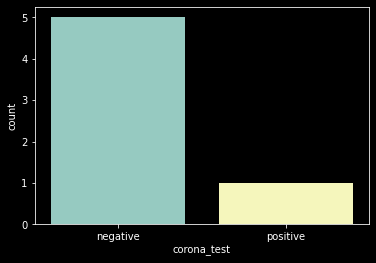

In [88]:
# The majority of patients in this dataset who had COVID-19 did have at least 
# one symptom. Only one patient was asymptomatic.
sns.countplot(x='corona_test', data=asympto_df);

### Audio Playground

In [89]:
# list of our first 10 virufy audio files in the 'pos' subfolder
os.listdir(audio_base_folder + 'pos')[:10]

['pos-0421-094-cough-m-51-4.mp3',
 'pos-0421-084-cough-m-50-7.mp3',
 'pos-0421-093-cough-f-24-6.mp3',
 'pos-0421-084-cough-m-50-6.mp3',
 'pos-0421-094-cough-m-51-2.mp3',
 'pos-0421-092-cough-m-53-1.mp3',
 'pos-0421-087-cough-f-40-5.mp3',
 'pos-0421-092-cough-m-53-0.mp3',
 'pos-0421-094-cough-m-51-6.mp3',
 'pos-0421-093-cough-f-24-2.mp3']

Viewing an audiofile using librosa

In [90]:
# positive audio example
audio_example = os.listdir(audio_base_folder +'pos')[4]
audio_example

'pos-0421-094-cough-m-51-2.mp3'

In [91]:
# negative audio example
audio_example2 = os.listdir(audio_base_folder +'neg')[4]
audio_example2

'neg-0422-095-cough-m-53-13.mp3'

In [92]:
target_audio = audio_base_folder+'pos/'+audio_example
target_audio

'/virufy_data-main/clinical/segmented/pos/pos-0421-094-cough-m-51-2.mp3'

In [93]:
target_audio2 = audio_base_folder+'neg/'+audio_example2
target_audio2

'/virufy_data-main/clinical/segmented/neg/neg-0422-095-cough-m-53-13.mp3'

In [94]:
# Viewing sample rate of the audio file
rate = AudioSegment.from_mp3(target_audio).frame_rate
rate

48000

In [95]:
target_rate = 48000
i = 0
for status in os.listdir(audio_base_folder):
  address = audio_base_folder + status
  for audiof in os.listdir(address):
    audio_address = address + '/' + audiof
    song = AudioSegment.from_mp3(audio_address)
    if song.frame_rate != target_rate:
      i += 1
    else:
      continue
print(f'Number of audio files that do not have a sample rate of 48000: {i}')

Number of audio files that do not have a sample rate of 48000: 0


We know that all the audio files in our virufy dataset have a sample rate of 48000

In [96]:
# two variables: the signal and the sample rate

#loading in a specific example to test out
signal, sr = librosa.load(target_audio, sr=48000)
len(signal), sr

(76796, 48000)

In [97]:
signal_def, sr_def = librosa.load(target_audio)
len(signal_def)

35279

In [98]:
neg_sig, sr = librosa.load(target_audio2, sr=48000)

In [99]:
# Librosa gives us back an array --> our audio signal
# and a number which represents our sample rate
# sample rate is how many samples we have in a second
# We get back the default sample rate, which is 22050
print(type(signal), type(sr))
print(signal.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(76796,) 48000


In [100]:
#Multiplying our sample rate by the length of our audio file
# It should give us back a float very close to the shape of our signal
48000 * 1.5999

76795.20000000001

In [101]:
# Viewing the internals of our signal variable
signal[:10]

array([-0.49084473, -0.56781006, -0.52178955, -0.5817261 , -0.6141968 ,
       -0.59143066, -0.5973511 , -0.54940796, -0.50567627, -0.5734558 ],
      dtype=float32)

In [102]:
# listening to the audio file
ipd.Audio(signal, rate=sr)

Visualizing our audio example's waveform using librosa.display (ldp)


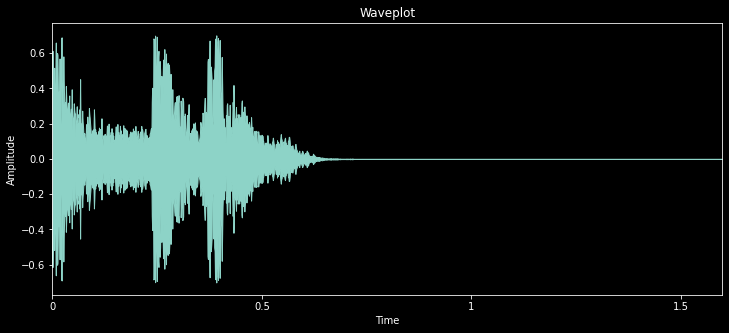

In [103]:
plt.figure(figsize=(12, 5))
ldp.waveplot(signal, sr=sr)
plt.title('Waveplot')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Text(0, 0.5, 'Magnitude')

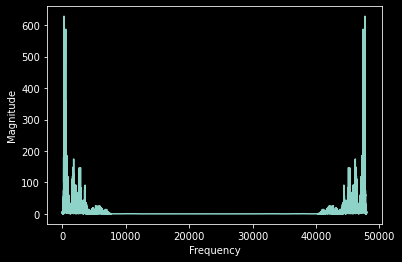

In [104]:
#Fast Fourier Transform
fft = np.fft.fft(signal)

# These magnitudes indicate the contribution of each frequency in the sound. The
# larger the magnitude, the heavier the contribution of the frequency.
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

# Plotting our Fast Fourier Transformation
plt.plot(frequency, magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

We notice the Fast Fourier Transformation plot is actually symmetrical. Without getting into too much detail (unnecessary for what we are doing), we only need the first half of the plot.

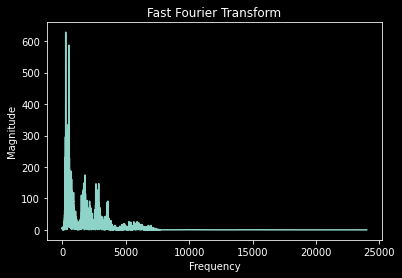

In [105]:
#Fast Fourier Transformation
fft = np.fft.fft(signal)

# These magnitudes indicate the contribution of each frequency in the sound
magnitude = np.abs(fft)

# mapping the magnitude to the relative frequency bins using np.linspace()
frequency = np.linspace(0, sr, len(magnitude))

# We only need the first half of the magnitude and frequency to visualize the FFT
left_mag = magnitude[:int(len(magnitude)/2)]
left_freq = frequency[:int(len(frequency)/2)]

plt.plot(left_freq, left_mag)
plt.title('Fast Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

Here we can see that the majority of the energy resides in the lower frequencies. The only issue with the FFT is the fact that it is static; there is no time associated with this plot. So in order to incorporate time into our audio to see what frequencies impact at what time, we should use the Short-Time Fourier Transformation.

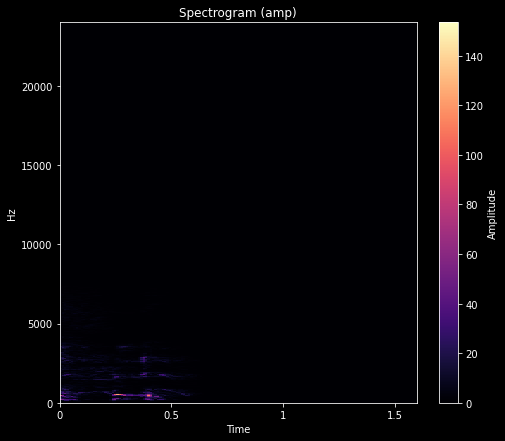

In [106]:
# number of samples per fft
# this is the number of samples in a window per fast fourier transform
n_fft = 2048

# The amount we are shifting each fourier transform (to the right)
hop_length = 512

#Trying out Short-time Fourier Transformation on our audio data
audio_stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

# gathering the absolute values for all values in our audio_stft variable
spectrogram = np.abs(audio_stft)

# Plotting the short-time Fourier Transformation
plt.figure(figsize=(8, 7))
ldp.specshow(spectrogram, sr=sr, x_axis='time', y_axis='hz', hop_length=hop_length)
plt.colorbar(label='Amplitude')
plt.title('Spectrogram (amp)')
plt.show()

As we can see (or not see), most of the frequencies in our audio contribute very little amplitude to the overall sound. 

Because what we are looking for is not linear, like loudness, we are going to take the log of our sounds amplitude and turn it into decibels.

Humans experience frequency logarithmically, not linearly.

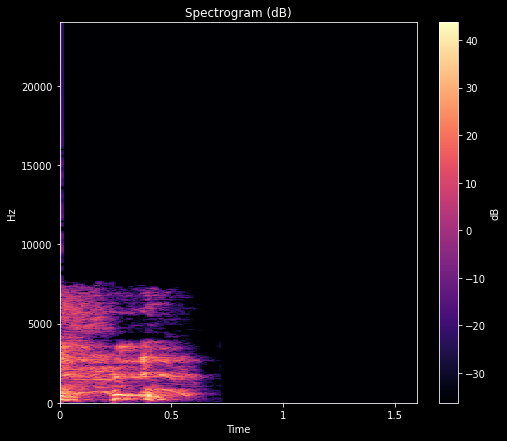

In [107]:
# Creating short-time Fourier Transformation
audio_stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

# converting values to absolute values
spectrogram = np.abs(audio_stft)

# here we are switching from amplitude scaling to decibel scaling
log_spectro = librosa.amplitude_to_db(spectrogram)

# Plotting the short-time fourier transformation
plt.figure(figsize=(8, 7))
ldp.specshow(log_spectro, sr=sr, x_axis='time', y_axis='hz', 
             hop_length=hop_length, cmap='magma')
plt.colorbar(label='dB')
plt.title('Spectrogram (dB)')
plt.show()

>By switching from a scale in amplitude to decibels, we create an image with more information to give to our model.

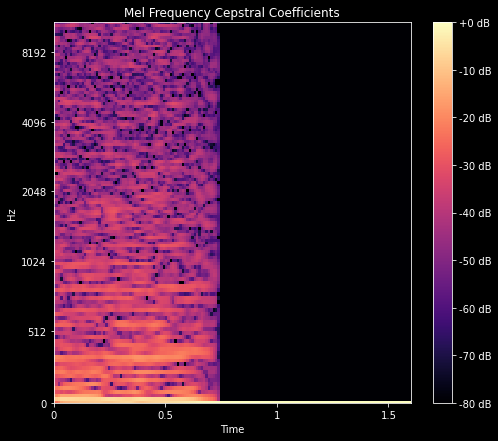

In [108]:
# Creating an MFCC plot
mfccs = librosa.feature.mfcc(signal, n_fft=4096, hop_length=512, n_mfcc=120, n_mels=512)

# PLotting the MFCCs
plt.figure(figsize=(8, 7))
ldp.specshow(librosa.amplitude_to_db(mfccs, ref=np.max), sr=sr, x_axis='time', y_axis='mel',
             hop_length=hop_length, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Frequency Cepstral Coefficients')
plt.show()

Fourier Transform:
- decompose complex periodic sound into sum of sine waves oscillating at different frequencies
- allows us to know the different elements that create a complex sound
- moves our audio from the time domain into the frequency domain
- it's a snapshot of the audio information

Short-Time Fourier Transform:
- computes several fourier transforms at different intervals
- doing so allows it to preserve information about time and the way the sound evolves over time
- makes it a time domain feature
- the amount different intervals are indicated by the frame size, which creates a spectrogram
- x-axis = time
- y-axis = frequency
- third axis = presence of a frequency
- the color tells us how prominent a certain frequency is at a certain period in time

Mel Frequency Cepstral Coefficients (MFCCs):
- Captures the timbral/textural aspects of sound
- time domain feature
- Approximated towards the human auditory system
- calculated at each frame
- usually want to use 13-40 coefficients for audio data
- usually used for speech recognition, music genre classification, music instrument classification
- could use MFCCs to help collect coughing audio data?

Mel Spectrograms:
- time-frequency representation
- perceptually relevant amplitude representation
- preceptually relevant frequency representation
- steps: extract stft, convert amplitude to dBs, convert frequency to mel-scale

to convert frequencies to the mel-scale:
1. choose a number of mel bands
2. construct mel filter banks
3. Apply filter banks to mel spectrogram

How many mel bands should you choose? Like learning rate, it depends on the problem.


In [109]:
def to_spectrogram(signal, sr, hop_length, n_fft=2048, ref=1, cmap='magma', 
                   fmax=9000, vmin=None, vmax=None, figsize=(10, 8)):
  """
  Definition:
  Plots a spectrogram of a signal.

  Args:
  signal: Required. An audio time series, usually an numpy 1 dimensional array.
  sr: Required. The sample rate of the signal.
  hop_length: Required. The amount to shift each fast fourier transform.
  n_fft: Required. The number of samples in a window per fast fourier transform.
  cmap: default = 'magma'. The color palette of the spectrogram.

  Returns:
  Plots a spectrogram via librosa.display.specshow()
  """
  stft_signal = librosa.core.stft(y=signal, hop_length=hop_length, n_fft=n_fft)
  spectrogram = np.abs(stft_signal)
  amp_to_db = librosa.amplitude_to_db(spectrogram, ref=ref)
  fig = plt.figure(figsize=figsize)
  if (vmin != None) and (vmax != None):
    ldp.specshow(amp_to_db, sr=sr, x_axis='time', y_axis='hz', cmap=cmap, 
                hop_length=hop_length, fmax=fmax, vmin=vmin, vmax=vmax)
  else:
    ldp.specshow(amp_to_db, sr=sr, x_axis='time', y_axis='hz', cmap=cmap, 
                hop_length=hop_length, fmax=fmax)
  plt.ylim(0, fmax)
  plt.colorbar(label='dB')
  # axes = fig.get_axes()
  # return fig, axes

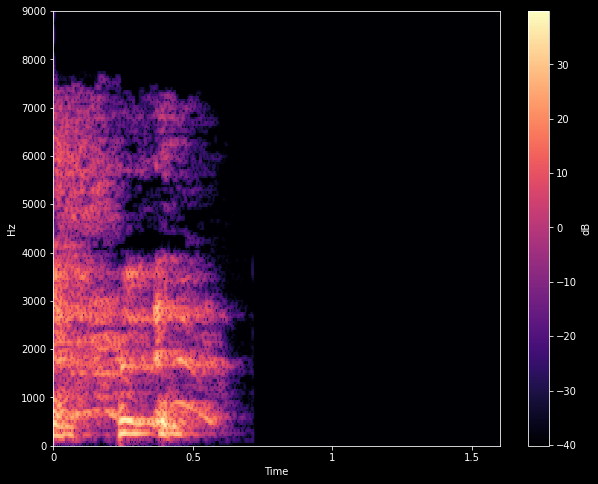

In [110]:
to_spectrogram(signal, sr=48000, hop_length=128, n_fft=1024)

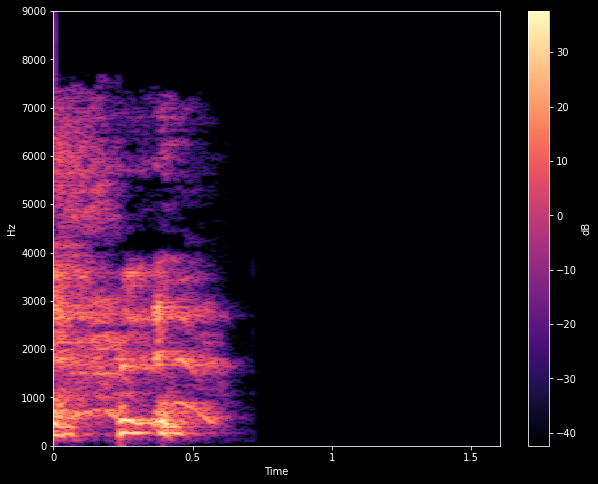

In [111]:
to_spectrogram(signal_def, sr=22050, hop_length=128, n_fft=1024)

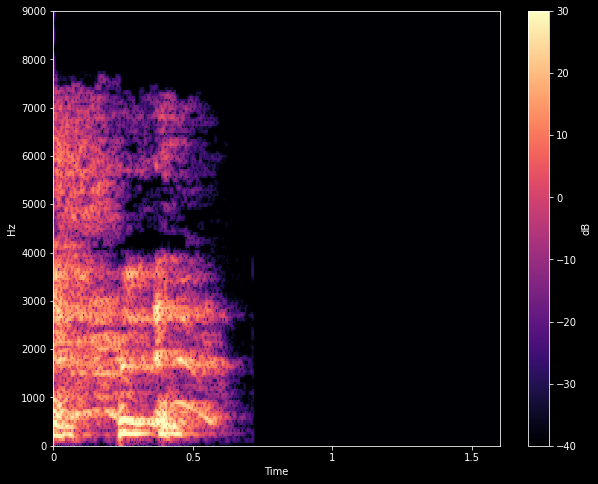

In [112]:
to_spectrogram(signal, sr=48000, hop_length=128, n_fft=1024, vmin=-40, vmax=30)

In [113]:
# listening to the audio file
ipd.Audio(signal, rate=sr)

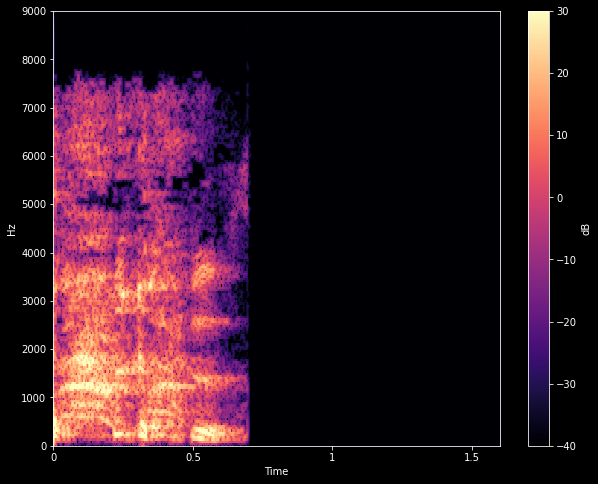

In [114]:
to_spectrogram(neg_sig, sr=48000, hop_length=128, n_fft=1024, 
                            vmin=-40, vmax=30)

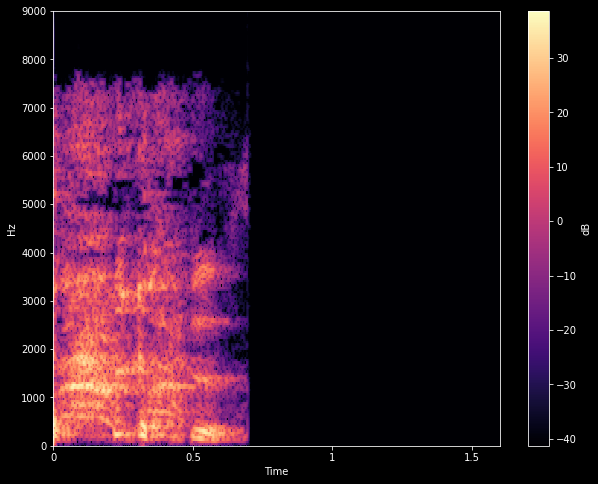

In [115]:
to_spectrogram(neg_sig, sr=48000, hop_length=128, n_fft=1024)

In [116]:
# listening to the audio file
ipd.Audio(neg_sig, rate=sr)

#### defining mel spectrogram function

In [117]:
def to_mel_spectro(signal, sr, hop_length, n_fft, cmap='magma', 
                    ref=np.max, figsize=(5, 4), vmin=None, vmax=None, n_mels=128):
  """
  Definition:
  Plots a mel-spectrogram of a signal.

  Args:
  signal: Required. An audio time series, usually an numpy 1 dimensional array.
  sr: Required. The sample rate of the signal.
  hop_length: Required. The amount to shift each fast fourier transform.
  n_fft: Required. The number of samples in a window per fast fourier transform.
  cmap: default = 'magma'. The color palette of the spectrogram.
  ref: default = np.max. Tells the librosa.power_to_db() how to scale the values.
  When ref=np.max, it will make the highest value 0, and everything else will be 
  lower than it, respectively so. Does not change the color distribution of the
  spectrogram.
  figsize: default = (10, 8). A tuple representing the desired figure size for 
  the plot.

  Returns:
  Plots a spectrogram via librosa.display.specshow()
  """

  mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=hop_length, 
                                              n_fft=n_fft, n_mels=n_mels)
  spectrogram = np.abs(mel_signal)
  power_to_db = librosa.power_to_db(spectrogram, ref=ref)
  plt.figure(figsize=figsize)
  if (vmin != None) and (vmax != None):
    ldp.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap=cmap, 
                hop_length=hop_length, vmin=vmin, vmax=vmax)
  else:
    ldp.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap=cmap, 
                hop_length=hop_length)
    
  plt.colorbar(label='dB')
  plt.show()

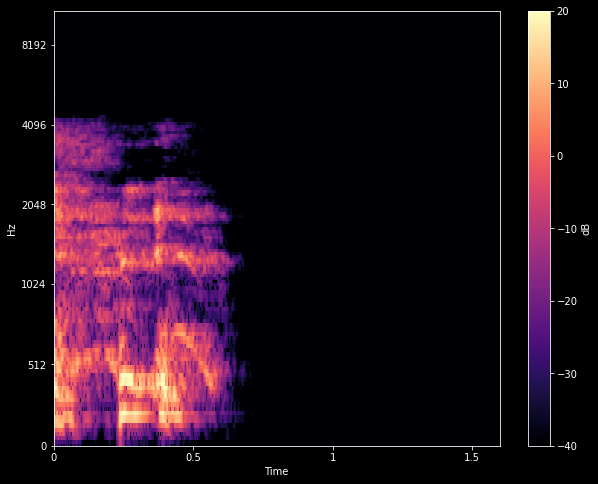

In [118]:
to_mel_spectro(signal, sr, hop_length=128, n_fft=1024, figsize=(10,8), vmin=-40, 
               vmax=20, ref=1, n_mels=128)

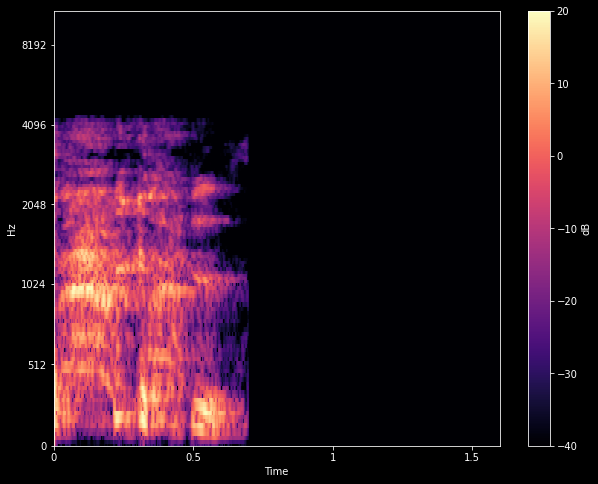

In [119]:
to_mel_spectro(neg_sig, sr, hop_length=128, n_fft=1024, figsize=(10,8), vmin=-40, 
               vmax=20, ref=1)

### Creating & Saving Mel-Spectrograms for Virufy Dataset

In [120]:
# Defining our target folder and constant variables
root_folder = '/virufy_data-main/clinical/segmented'
SAMPLE_RATE = 48000
HOP_LENGTH = 128
N_FFT = 1024

start = time.time()

# Going through 'pos' and 'neg' folders in root folder
for status in os.listdir(root_folder):

  # Identifying correct directory for each 'pos' and 'neg' subfolder and
  # accessing each audio file within these folders
  step = root_folder + '/' + status
  for subfile in os.listdir(step):
    # Creating a variable that holds the filepath for an audio file
    audio_file = step + '/' + subfile
    # Loading the signal and sample rate for an audio file
    signal, sr = librosa.load(audio_file, sr=SAMPLE_RATE)

    # Calling plt.interactive(False) means that we choose to manually show and destroy
    # our plots 
    plt.interactive(False)

    # Creating our mel-spectrograms
    mel_signal = librosa.feature.melspectrogram(y=signal, sr=SAMPLE_RATE, 
                                                hop_length=HOP_LENGTH, 
                                                n_fft=N_FFT)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
    # Creating figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    # Hiding axes and image frame
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    # Displaying our spectrograms
    ldp.specshow(power_to_db, sr=SAMPLE_RATE, cmap='magma', hop_length=HOP_LENGTH)
    # making folder to store images
    new_folder = '/viru_melspectro_images/' + status + '/'
    os.makedirs(new_folder , exist_ok=True)
    
    # Saving each spectrogram into its respective folder
    # subfile[:-4] is a string of the subfile without the ending extension '.mp3'
    # We add the '.png' extension to the end of our new spectrogram images instead
    plt.savefig(fname=new_folder + subfile[:-4] + '.png', dpi=400, 
                bbox_inches='tight',pad_inches=0)
    
    # We then manually close pyplot, clear the figure, close the fig variable, 
    # and then close the figure window
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')

# Display the time it took to run the cell in seconds
end = time.time()
time_count(start, end)

Time to run cell: 181 seconds


In [121]:
# Comparing pos and neg spectrogram images we created
neg_img = mpimg.imread('/viru_melspectro_images/neg/neg-0421-083-cough-m-53-0.png')
pos_img = mpimg.imread('/viru_melspectro_images/pos/pos-0421-084-cough-m-50-0.png')

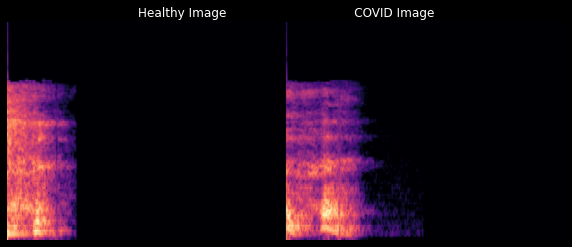

In [122]:
# Using np.hstack() to show our images side by side
res = np.hstack((neg_img, pos_img))
# Creating a figure and adding a subplot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# plotting the horizontal stack using plt.imshow()
plt.imshow(res, cmap='gray')
plt.title('Healthy Image                                 COVID Image')

# Hiding our axes and frame
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.show()

When looking at the spectrograms, there's not much we can take away just by looking at them. We notice the coughs are roughly the same length in duration, and the prominence of some frequencies of sound may be slightly different when comparing patients (male vs female, older vs younger, etc). 

### Modeling off of the virufy spectrogram images

In [123]:
# Creating train, test, val folders for our virufy dataset
run = 1
base_folder = '/viru_melspectro_images'
if run:
  splitfolders.ratio(input=base_folder, 
                    output='/virufy_spectro_ttv', 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio order: train, val, test
else:
  print('Did not run')

Copying files: 121 files [00:00, 4282.90 files/s]


In [124]:
folder_check('/virufy_spectro_ttv')

/virufy_spectro_ttv/train/
Number of items in neg: 51
Number of items in pos: 33
Total number of items: 84

/virufy_spectro_ttv/test/
Number of items in neg: 15
Number of items in pos: 11
Total number of items: 26

/virufy_spectro_ttv/val/
Number of items in neg: 7
Number of items in pos: 4
Total number of items: 11


Total image count: 121


In [125]:
virufy_train_folder, virufy_test_folder, virufy_val_folder =create_ttv('/virufy_spectro_ttv')

In [130]:
# Defining our image size
IMG_SIZE = (300,240)

# Creating ImageDataGenerators for train and test/val
viru_train_datagen = ImageDataGenerator(rescale=1./255, 
                                        #width_shift_range=0.1, 
                                        brightness_range=(0.9, 1.2))
viru_test_val_datagen = ImageDataGenerator(rescale=1./255)

In [131]:
viru_train_gen = viru_train_datagen.flow_from_directory(virufy_train_folder, 
                                                        target_size=IMG_SIZE,
                                                        batch_size=32, 
                                                        class_mode='binary')
                                                        
viru_test_gen = viru_test_val_datagen.flow_from_directory(virufy_test_folder, 
                                                        target_size=IMG_SIZE,
                                                        batch_size=32, 
                                                        class_mode='binary', 
                                                        shuffle=False)

viru_val_gen = viru_test_val_datagen.flow_from_directory(virufy_val_folder,
                                                        target_size=IMG_SIZE,
                                                        batch_size=32, 
                                                        class_mode='binary')

Found 84 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


In [132]:
class_weights_dict = make_class_weights(viru_train_gen)
INPUT_SHAPE = viru_train_gen.image_shape
print(INPUT_SHAPE)

{0: 0.8235294117647058, 1: 1.2727272727272727}
(300, 240, 3)


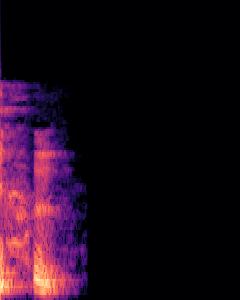

In [133]:
ex_image = next(viru_train_gen)[0][0]
array_to_img(ex_image)

In [134]:
def viru_spectro_model(shape='', opt=tf.keras.optimizers.Adam(), 
                        metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall'), 
                                        tf.keras.metrics.AUC(name='auc')],
                        loss='binary_crossentropy', 
                        verbose=1):
  """
  Definition:
  Creates and compiles a neural network model. 

  Args:
  shape: default = ''. The input shape of the images to be passed in to the 
  neural network. The size must be the same as the images being passed in.
  metrics: default = ['acc', tf.keras.metrics.Precision(name='precision'),
                             tf.keras.metrics.Recall(name='recall'), 
                             tf.keras.metrics.AUC(name='auc')].
           The metrics that are to be analyzed and plotted from the 
           training of the model.
  verbose: default = 1. If 1, prints a summary of the model upon compilation.

  Returns:
  The model, along with the model.summary() if verbose = 1.
  """
  if len(shape) < 1:
    print('Please define input shape!')
  else:
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=shape))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))

    # model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(128, activation='relu'))
    #model.add(layers.Dropout(0.2))

    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(32, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    if verbose:
      print(model.summary())
    return model

In [135]:
def viru_lstm_model(shape='', opt=tf.keras.optimizers.Adam(), 
                        metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall'), 
                                        tf.keras.metrics.AUC(name='auc')],
                        loss='binary_crossentropy', 
                        verbose=1):
  
  model = Sequential()
  model.add(layers.LSTM(128, activation='relu', return_sequences=True, input_shape=shape))
  model.add(layers.Dropout(0.2))

  model.add(layers.LSTM(128, activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(32))

  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss=loss, optimizer=opt, metrics=metrics)
  if verbose:
    print(model.summary())
  return model

In [136]:
viru_model1 = viru_spectro_model(shape=INPUT_SHAPE, opt=tf.keras.optimizers.Adam(0.001, decay=0.0001))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 298, 238, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 149, 119, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 147, 117, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 58, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 270976)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               138740224 
_________________________________________________________________
dropout (Dropout)            (None, 512)              

Epoch 1/25
3/3 [==============================] - 13s 5s/step - loss: 0.7216 - acc: 0.4906 - precision: 0.3824 - recall: 0.6806 - auc: 0.5210 - val_loss: 0.6789 - val_acc: 0.6364 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.7857
Epoch 2/25
3/3 [==============================] - 10s 3s/step - loss: 0.6920 - acc: 0.5865 - precision: 0.4667 - recall: 0.5710 - auc: 0.5913 - val_loss: 0.6050 - val_acc: 0.8182 - val_precision: 0.6667 - val_recall: 1.0000 - val_auc: 0.8750
Epoch 3/25
3/3 [==============================] - 10s 4s/step - loss: 0.6547 - acc: 0.6039 - precision: 0.4579 - recall: 0.5616 - auc: 0.6828 - val_loss: 0.5907 - val_acc: 0.8182 - val_precision: 0.6667 - val_recall: 1.0000 - val_auc: 0.8571
Epoch 4/25
3/3 [==============================] - 10s 3s/step - loss: 0.6016 - acc: 0.6456 - precision: 0.5423 - recall: 0.6875 - auc: 0.7735 - val_loss: 0.4359 - val_acc: 0.7273 - val_precision: 0.6000 - val_recall: 0.7500 - val_auc: 0.9286
Epoch 5/25
3/3 [================

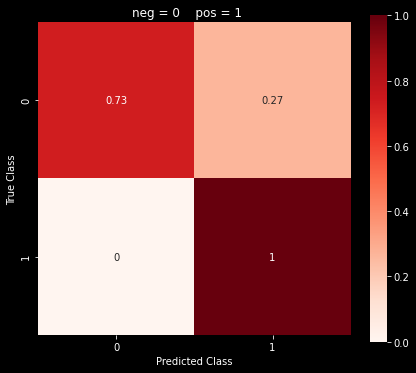

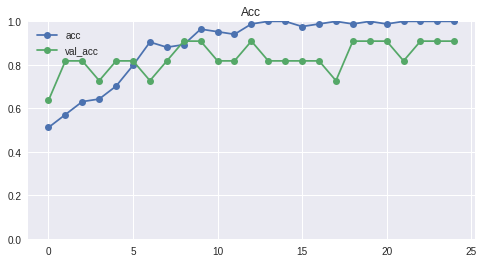

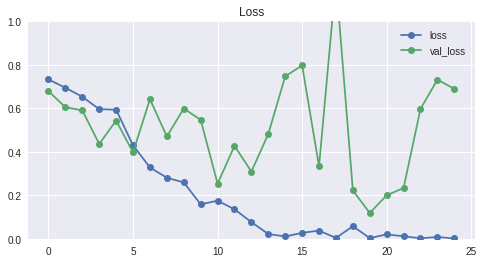

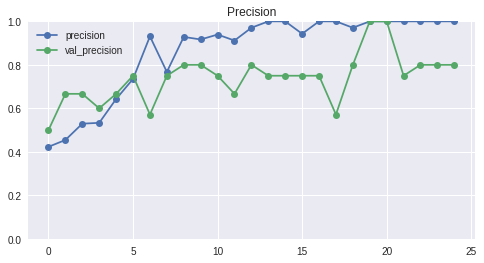

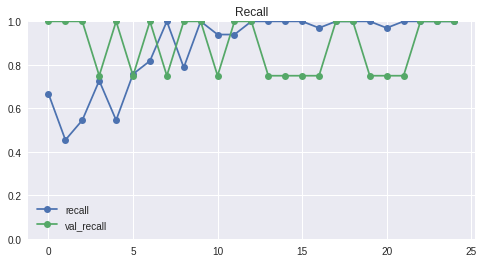

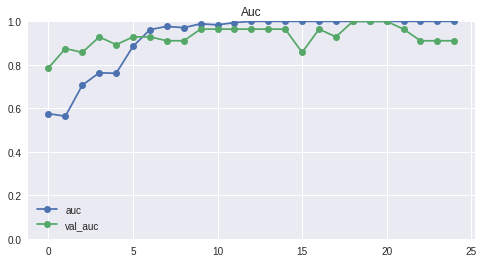

------------------------------------------------------------
1/1 [==============================] - 3s 3s/step - loss: 0.9429 - acc: 0.8462 - precision: 0.7333 - recall: 1.0000 - auc: 0.9273
loss score: 0.9428609013557434
accuracy score: 0.8461538553237915
precision score: 0.7333333492279053
recall score: 1.0
auc score: 0.9272727370262146

Time to run cell: 270 seconds


In [137]:
viru_hist1 = fit_plot_report_gen(viru_model1, viru_train_gen, viru_test_gen, 
                                 viru_val_gen, epochs=25, 
                                 class_weights=class_weights_dict)

In [163]:
save_model(viru_model1, 
           '/content/drive/MyDrive/gdrive/models/capstone_models/viru_spectro_models/viru_model1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/gdrive/models/capstone_models/viru_spectro_models/viru_model1/assets


We seem to be getting an ok accuracy with our model. However, when it comes to classifying our spectrogram images with a basic model we've created, the dataset we are working with is too small - only containing around 16 different patients with 121 segmented audio samples. Let's get more audio data from the coughvid dataset and combine it with the virufy dataset.

#### Reducing the length of audio data example

In [138]:
signal, sr = librosa.load(target_audio)
# Trim the beginning and ending silence in our signal
trimmed_sig, index = librosa.effects.trim(signal)
# Print the durations of the original signal and the trimmed signal
print(librosa.get_duration(signal), librosa.get_duration(trimmed_sig))

1.5999546485260772 0.7662585034013606


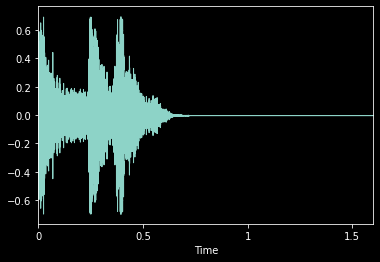

In [139]:
# Original wave of signal
ldp.waveplot(signal)

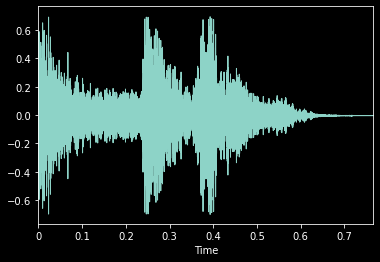

In [140]:
# Trimmed wave of signal
ldp.waveplot(trimmed_sig)

#### Time stretch example

In [141]:
# Calculating the delay so we can stretch our trimmed audio to match the 
# original length of the signal
delay = librosa.get_duration(trimmed_sig) / librosa.get_duration(signal)
delay

0.47892513960146266

In [142]:
# Creating the slowed version of our trimmed signal
slow_signal = librosa.effects.time_stretch(trimmed_sig, delay)

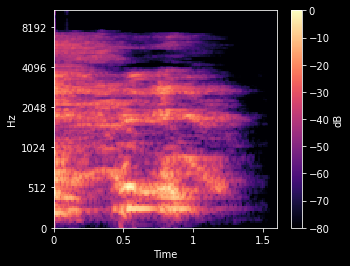

In [143]:
# Viewing our slowed signal as a mel-spectrogram
to_mel_spectro(slow_signal, sr, hop_length=256, n_fft=1024, figsize=(5, 4))

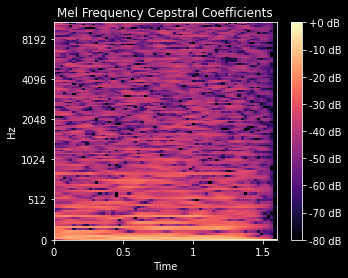

In [144]:
# Creating an MFCC plot
mfccs = librosa.feature.mfcc(slow_signal, n_fft=4096, hop_length=512, n_mfcc=120, n_mels=512)

# PLotting the MFCCs
plt.figure(figsize=(5, 4))
ldp.specshow(librosa.amplitude_to_db(mfccs, ref=np.max), sr=sr, x_axis='time', y_axis='mel',
             hop_length=hop_length, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Frequency Cepstral Coefficients')
plt.show()

### Creating virufy MFCC images with audio trimming and time stretch preprocessing techniques

In [148]:
# Defining our target folder and constant variables
root_folder = '/virufy_data-main/clinical/segmented/'
new_folder = '/virufy_reduced_audio/'
SAMPLE_RATE = 48000

start = time.time()

# Going through 'pos' and 'neg' folders in root folder
for status in os.listdir(root_folder):

  # Identifying correct directory for each 'pos' and 'neg' subfolder and
  # accessing each audio file within these folders
  step = root_folder + status
  # Creating new folder with subfolders
  os.makedirs(new_folder + status, exist_ok=True)
  for subfile in os.listdir(step):
    # Creating a variable that holds the filepath for an audio file
    audio_file = step + '/' + subfile
    # Loading the signal and sample rate for an audio file
    signal, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
    # trimming the signal
    trimmed_sig, index = librosa.effects.trim(signal)
    # saving the audio
    tag = audio_file.split('/')[-1][:-4]
    #print(tag)
    # Saving the trimmed audio in a new directory
    sf.write(new_folder + status + '/' + tag + '.wav', 
                             data=trimmed_sig, samplerate=sr)
    
# Display the time it took to run the cell in seconds
end = time.time()
time_count(start, end)

Time to run cell: 46 seconds


In [149]:
def get_audio_duration(root_dir):
  """
  Definition:
  Finds the duration of each audio file in a folder, uses the librosa library to
  get the time duration for each file, and appends each duration to a list called 
  duration_list. This list is then transformed into a dataframe, and then returned
  and the function output.

  Args:
  root_dir: Required. Specify the folder that holds the audio files.

  Returns:
  A dataframe that holds the duration for each audio file and prints the amount
  of time it took to run the function.
  """
  
  duration_list = []
  start = time.time()
  if root_dir[-1] != '/':
    root_dir = root_dir + '/'
  for status in os.listdir(root_dir):
    address = root_dir + status + '/'
    for audiofile in os.listdir(address):
      try:
        # setting the variable audio_time and giving it the duration of the file
        audio_time = librosa.get_duration(filename=address+audiofile)
        # appending the audio_time variable to our list
        duration_list.append(audio_time)
      except:
        # Adding 0 if we can't extract the duration. We should not get any zeros
        duration_list.append(0)

  df = pd.Series(duration_list, name='duration').to_frame()

  end = time.time()
  time_count(start, end)
  return df

In [150]:
viru_reduced_df = get_audio_duration('/virufy_reduced_audio')

Time to run cell: 0 seconds


In [151]:
viru_reduced_df['duration'].describe()

count    121.000000
mean       0.683636
std        0.199493
min        0.373333
25%        0.512000
50%        0.650667
75%        0.800000
max        1.269333
Name: duration, dtype: float64

The max duration from our reduced audio samples is now 1.2 seconds. We managed to shave off 0.4 seconds from our original max duration of 1.6 seconds. Now let's create MFCC images and incorporate the time_stretch() function to make all of the files the same length.

In [152]:
# Defining our target folder and constant variables
root_folder = '/virufy_reduced_audio/'
new_folder = '/virufy_stretched_mfccs/'
SAMPLE_RATE = 48000
HOP_LENGTH = 512
N_FFT = 4096
N_MFCC = 120
N_MELS = 512
MAX_DUR = 1.269333
REF = np.max

start = time.time()

# Going through 'pos' and 'neg' folders in root folder
for status in os.listdir(root_folder):

  # Identifying correct directory for each 'pos' and 'neg' subfolder and
  # accessing each audio file within these folders
  step = root_folder + status
  # Creating new folder with subfolders
  os.makedirs(new_folder + status, exist_ok=True)
  for subfile in os.listdir(step):
    # Creating a variable that holds the filepath for an audio file
    audio_file = step + '/' + subfile
    # Loading the signal and sample rate for an audio file
    signal, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
    # Calculating the delay - we are using the 75th percentile (0.8) as the 
    # target max duration for our audio files
    delay = librosa.get_duration(signal) / MAX_DUR
    # Creating the slowed version of our trimmed signal
    slow_signal = librosa.effects.time_stretch(signal, delay)

    plt.interactive(False)
    # Creating our mel-spectrograms
    mfccs = librosa.feature.mfcc(slow_signal, n_fft=N_FFT, hop_length=HOP_LENGTH, 
                                 n_mfcc=N_MFCC, n_mels=N_MELS)

    # Creating figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    # Hiding axes and image frame
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    # Displaying our spectrograms
    ldp.specshow(librosa.amplitude_to_db(mfccs, ref=REF), sr=SAMPLE_RATE, 
                 hop_length=HOP_LENGTH, cmap='magma')

    # Saving each spectrogram into its respective folder
    # subfile[:-4] is a string of the subfile without the ending extension '.wav'
    # We add the '.png' extension to the end of our new spectrogram images instead
    plt.savefig(fname=new_folder + status + '/' + subfile[:-4] + '.png', dpi=400, 
                bbox_inches='tight', pad_inches=0)
    
    # We then manually close pyplot, clear the figure, close the fig variable, 
    # and then close the figure window
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')

# Display the time it took to run the cell in seconds
end = time.time()
time_count(start, end)

Time to run cell: 123 seconds


Saved image shape: (2416, 3100)


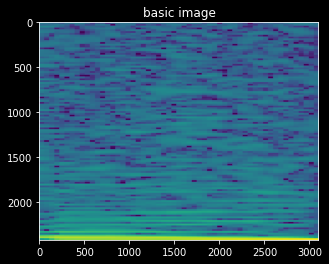

In [153]:
# Viewing a MFCC and it's dimensions
img = cv2.imread('/virufy_stretched_mfccs/neg/neg-0421-083-cough-m-53-0.png', 0)

print(f"Saved image shape: {img.shape}")
plt.title('basic image')
plt.imshow(img);

In [154]:
# Splitting our preprocess image folder into train, test, and validation subfolders
# in a new directory
run=1
if run:
  splitfolders.ratio(input='/virufy_stretched_mfccs', 
                    output='/viru_mfcc_ttv/', 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio of data sharing for
                                                    # train, test, val folders

Copying files: 121 files [00:00, 5306.14 files/s]


In [155]:
vmfcc_train_folder, vmfcc_test_folder, vmfcc_val_folder = create_ttv('/viru_mfcc_ttv')

In [156]:
# Defining our image size
IMG_SIZE = (300, 240)

# Creating ImageDataGenerators for train and test/val
viru_mfcc_train_datagen = ImageDataGenerator(rescale=1./255)
viru_mfcc_test_val_datagen = ImageDataGenerator(rescale=1./255)

In [157]:
viru_mfcc_train_gen = viru_mfcc_train_datagen.flow_from_directory(vmfcc_train_folder, 
                                                        target_size=IMG_SIZE,
                                                        batch_size=20, 
                                                        class_mode='binary')
                                                        
viru_mfcc_test_gen = viru_mfcc_test_val_datagen.flow_from_directory(vmfcc_test_folder, 
                                                        target_size=IMG_SIZE,
                                                        batch_size=20, 
                                                        class_mode='binary', 
                                                        shuffle=False)

viru_mfcc_val_gen = viru_mfcc_test_val_datagen.flow_from_directory(vmfcc_val_folder,
                                                        target_size=IMG_SIZE,
                                                        batch_size=20, 
                                                        class_mode='binary')

Found 84 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


In [158]:
class_weights_dict = make_class_weights(viru_mfcc_train_gen)
INPUT_SHAPE = viru_mfcc_train_gen.image_shape

{0: 0.8235294117647058, 1: 1.2727272727272727}


In [159]:
vmfcc_model1 = viru_spectro_model(INPUT_SHAPE)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 298, 238, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 149, 119, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 147, 117, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 73, 58, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 270976)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               138740224 
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [160]:
vmfcc_hist = fit_plot_report_gen(vmfcc_model1, viru_mfcc_train_gen, viru_mfcc_test_gen, 
                                 viru_mfcc_val_gen, class_weights=class_weights_dict, batch_size=20, 
                                 epochs=20)

Epoch 1/20
5/5 [==============================] - 12s 2s/step - loss: 1.7224 - acc: 0.5536 - precision: 0.5921 - recall: 0.5598 - auc: 0.6714 - val_loss: 0.8543 - val_acc: 0.6364 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3393
Epoch 2/20
5/5 [==============================] - 10s 2s/step - loss: 1.3003 - acc: 0.3995 - precision: 0.2309 - recall: 0.3191 - auc: 0.4280 - val_loss: 0.7148 - val_acc: 0.3636 - val_precision: 0.3636 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/20
5/5 [==============================] - 10s 2s/step - loss: 0.6811 - acc: 0.5341 - precision: 0.4871 - recall: 0.9212 - auc: 0.5979 - val_loss: 0.7008 - val_acc: 0.3636 - val_precision: 0.3636 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 4/20
5/5 [==============================] - 10s 2s/step - loss: 0.6877 - acc: 0.3957 - precision: 0.2496 - recall: 0.3186 - auc: 0.4630 - val_loss: 0.6928 - val_acc: 0.4545 - val_precision: 0.4000 - val_recall: 1.0000 - val_auc: 0.8571
Epoch 5/20
5/5 [========

KeyboardInterrupt: ignored

#### Extending the length of audio data example

Since our first audio dataset consists of audio files with the exact length of 1.6 seconds, and our second dataset consists of audiofiles with a length of up to 10 seconds, we will need to fill in silent frames into our smaller audio files.

link: https://stackoverflow.com/questions/46757852/adding-silent-frame-to-wav-file-using-python

In [ ]:
# Address of example we are going to work with
target_audio

'/virufy_data-main/clinical/segmented/pos/pos-0421-092-cough-m-53-5.mp3'

In [ ]:
signal, sr = librosa.load(target_audio)
max_duration = 10 # in seconds
duration = librosa.get_duration(signal, sr)
print(duration)

1.5999092970521542


In [ ]:
silent_length = (max_duration*1000) - (duration*1000)
print(int(silent_length))

0


In [ ]:
# creating 8.4 secs of audio silence -- duration in milliseconds
silent_segment = AudioSegment.silent(duration=silent_length)

In [ ]:
#read our target wav file example to an audio segment
cough_audio = AudioSegment.from_mp3(target_audio)

In [ ]:
# Combining our silent segment with the audio example
extended_cough = cough_audio + silent_segment

In [ ]:
# Viewing our extended_cough variable's type
type(extended_cough)

pydub.audio_segment.AudioSegment

In [ ]:
# making a folder to hold our extended audio example
os.makedirs('/ext_audio_test', exist_ok=True)

In [ ]:
extended_cough.export(out_f='/ext_audio_test/extended_cough2.mp3')

<_io.BufferedRandom name='/ext_audio_test/extended_cough2.mp3'>

In [ ]:
signal, sr = librosa.load('/ext_audio_test/extended_cough2.mp3', sr=22050)

In [ ]:
ipd.Audio(signal, rate=sr)

In [ ]:
# length of our extended audio file
duration = librosa.get_duration(signal, sr)
print(duration)

1.5999092970521542


In [ ]:
shutil.rmtree('/ext_audio_test')

## Obtaining CoughVid audio data

Unzipping folder containing the CoughVid dataset and audio files

In [ ]:
# Extracting the contents of our cooughvid zipped folder

start = time.time()
file_name='/content/drive/MyDrive/public_dataset.zip'
with ZipFile(file_name,'r') as zip:
      zip.extractall()
      print('Done')
end = time.time()
time_count(start, end)

Done
Time to run cell: 15 seconds


In [ ]:
# Reading in the csv file into a dataframe
coughvid_df = pd.read_csv('/public_dataset/metadata_compiled.csv')

In [ ]:
coughvid_df.head()

,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,cough_type_3,diagnosis_3,severity_3
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,31.3,34.8,15.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,40.0,-75.1,34.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0012c608-33d0-4ef7-bde3-75a0b1a0024e,2020-04-15T01:03:59.029326+00:00,0.0482,-16.5,-71.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,2020-04-13T22:23:06.997578+00:00,0.9968,NaN,NaN,21.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001c85a8-cc4d-4921-9297-848be52d4715,2020-04-17T15:24:35.822355+00:00,0.0735,40.6,-3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


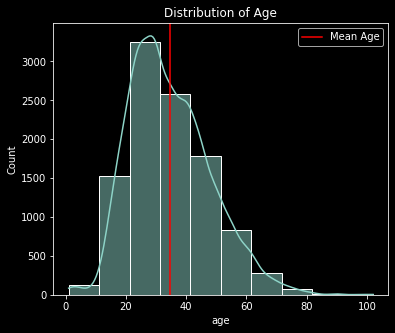

In [ ]:
# Viewing the distribution of age in coughvid dataset
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=coughvid_df, x='age', bins=10, kde=True)
plt.axvline(x=coughvid_df['age'].mean(), c = 'r', label='Mean Age')
plt.title('Distribution of Age')
plt.legend()
plt.show()

### Column information

>- **uuid**: The address of the associated audio and json file for a patient.
- **datetime**: Timestamp of the received recording in ISO 8601
format.
- **cough_detected**: Probability that the recording contains cough sounds, according to the automatic detection algorithm
that was used by Orlandic et al.
- **latitude**: Self-reported latitude geolocation coordinate with reduced precision.
- **longitude**: Self-reported longitude geolocation coordinate with reduced precision.
- **age**: Self-reported age value.
- **gender**: Self-reported gender.
- **respiratory_condition**: If the patient has other respiratory conditions (self-reported).
- **fever_muscle_pain**: If the patient has a fever or muscle pain (self-reported).
- **status**: The patient self-reports that has been diagnosed with COVID-19 (COVID), that has symptoms but no diagnosis (symptomatic), or that is healthy (healthy).

>Within the next set of columns, it is important to know that 3 expert pulmonologists were each assigned with revising 1000 recordings to enhance the quality of the dataset with clinically validated information. They selected one of the predefined options to each of the following 10 items:



>**Categorical Columns**:
- **quality**: quality of the recorded cough sound.
  - values: {good, ok, poor, no_cough} 
- **cough_type**: Type of the cough.
  - values:  {wet, dry, unknown}
- **diagnosis**: Impression of the expert about the condition of the patient. It can be an upper or lower respiratory tract
infection, an obstructive disease (Asthma, COPD, etc), COVID-19, or a healthy cough.
  - values: {upper_infection, lower_infection, obstructive_disease, COVID-19, healthy_cough}
- **severity**: Impression of the expert about the severity of the cough. It can be a pseudocough from a healthy patient, a mild or severe cough from a sick patient, or unknown if the expert can’t tell.
  - values: {pseudocough, mild, severe, unknown}

>**Boolean Columns**:
- **dyspnea**: Presence of any audible dyspnea.
- **wheezing**: Presence of any audible wheezing.
- **stridor**: Presence of any audible stridor.
- **choking**: Presence of any audible choking.
- **congestion**: Presence of any audible nasal congestion.
- **nothing**: Nothing specific is audible.


In [ ]:
print("Percent of null values for each column:")
for col in coughvid_df.columns:
  print(f"{col}: {round(coughvid_df[col].isna().sum()/len(coughvid_df), 3)}")

Percent of null values for each column:
uuid: 0.0
datetime: 0.0
cough_detected: 0.0
latitude: 0.415
longitude: 0.415
age: 0.478
gender: 0.436
respiratory_condition: 0.436
fever_muscle_pain: 0.436
status: 0.436
quality_1: 0.959
cough_type_1: 0.959
dyspnea_1: 0.959
wheezing_1: 0.959
stridor_1: 0.959
choking_1: 0.959
congestion_1: 0.959
nothing_1: 0.959
diagnosis_1: 0.959
severity_1: 0.959
quality_2: 0.959
cough_type_2: 0.959
dyspnea_2: 0.959
wheezing_2: 0.959
stridor_2: 0.959
choking_2: 0.959
congestion_2: 0.959
nothing_2: 0.959
diagnosis_2: 0.959
severity_2: 0.959
quality_3: 0.959
dyspnea_3: 0.959
wheezing_3: 0.959
stridor_3: 0.959
choking_3: 0.959
congestion_3: 0.959
nothing_3: 0.959
cough_type_3: 0.96
diagnosis_3: 0.96
severity_3: 0.96


We see that the majority of our data have missing values in the expert columns. This is expected because they each reviewed only 1000 audio files, therefore the majority of these values should be missing. Also note that about 15% of the recordings were labeled by all three reviewers, so that Orlandic et al. could assess the level of agreement among the pulmonologists.


In [ ]:
# Dataframe containing rows that were reviewed by one or more pulmonologist
expert_df = coughvid_df[(coughvid_df['quality_1'].notnull()) | 
                        (coughvid_df['quality_2'].notnull()) | 
                        (coughvid_df['quality_3'].notnull())]

In [ ]:
len(expert_df)

2200

In [ ]:
expert_df.head()

,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,cough_type_3,diagnosis_3,severity_3
11,002db0bd-e57f-4c30-ade0-16640d424eb7,2020-04-13T19:51:11.397697+00:00,0.9536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,False,False,False,True,unknown,healthy_cough,pseudocough
27,005b8518-03ba-4bf5-86d2-005541442357,2020-04-14T20:16:53.677536+00:00,0.9854,45.2,19.7,23.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,dry,False,False,False,False,False,True,lower_infection,mild,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,006d8d1c-2bf6-46a6-8ef2-1823898a4733,2020-04-22T10:24:21.408615+00:00,0.2677,NaN,NaN,28.0,male,True,True,symptomatic,ok,dry,False,False,False,False,False,True,healthy_cough,pseudocough,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,008ba489-31ad-44d8-856b-fcf72369dc46,2020-04-13T23:09:36.585124+00:00,0.9962,38.1,-122.2,28.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,True,False,False,False,wet,lower_infection,mild
48,008c1c9e-aeef-40c5-846c-24f1b964f884,2020-04-12T21:25:00.131353+00:00,0.9751,48.9,2.7,44.0,male,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,False,False,False,True,wet,healthy_cough,pseudocough


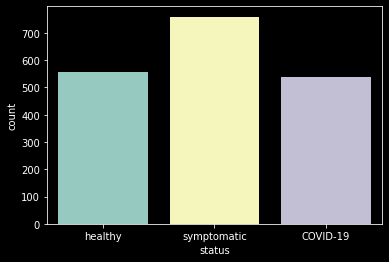

In [ ]:
sns.countplot(data=expert_df, x='status')

In [ ]:
# Saving our expert_df into our permanent folder
run=0
if run:
  expert_df.to_csv('/content/drive/MyDrive/gdrive/capstone/created_dfs/expert_df.csv', index=False)

Our Reasoning for setting the threshold of cough_detection >= 0.8:

According to Orlandic et al., "the ROC curve of the cough classifier is displayed below, which users of the COUGHVID database can consult to set a cough detection threshold that suits their specifications. As this figure shows, only 10.4% of recordings with a cough_detected value less than 0.8 actually contain cough sounds. Therefore, they should be used only for robustness assessment, and not as valid cough examples."


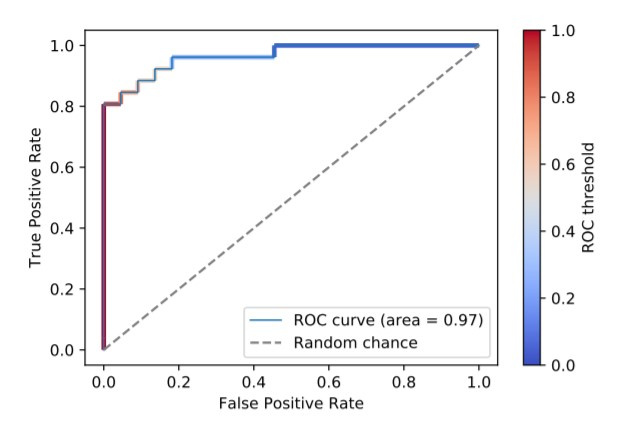

MUST CITE THIS PROPERLY!!
Figure from: L. Orlandic, T. Teijeiro, D. Atienza, The coughvid crowdsourcing
dataset: A corpus for the study of large-scale cough analysis algorithms, arXiv preprint arXiv:2009.11644 (2020)

In [ ]:
# Setting the threshold of cough detection needing to be 80% or greater
cough_df = coughvid_df[coughvid_df['cough_detected'] >= 0.8]

In [ ]:
# We've cut our dataset in half, but since we are focused on training a model to 
# detect COVID-19 through coughing audio, we must make sure that we feed it the 
# audio that actually contains coughing.

len(cough_df)

10746

In [ ]:
# Making sure there are no duplicates in our UUID column
cough_df['uuid'].nunique()

10746

The values within the 'status' column:

The patient self-reports that have been diagnosed with COVID-19 (COVID), that has symptoms but no diagnosis (symptomatic), or that is healthy (healthy).


In [ ]:
# Inspecting counts of each value in 'status' column
cough_df['status'].value_counts()

healthy        5628
symptomatic    1135
COVID-19        547
Name: status, dtype: int64

In [ ]:
# Inspecting count of null values within our 'status' column
cough_df['status'].isna().sum()

3436

In [ ]:
# Since our target variable is the 'status' column, wouldn't it make sense for us
# to remove any null values from this column?

In [ ]:
# Checking the quality of the coughing audio labeled by each expert
quality_check = ['quality_1', 'quality_2', 'quality_3']
for col in quality_check:
  print(f"{cough_df[col].value_counts()}\n")


ok          504
poor        127
good         30
no_cough      7
Name: quality_1, dtype: int64

good        391
ok          229
poor         52
no_cough      6
Name: quality_2, dtype: int64

good        625
ok           21
poor          9
no_cough      8
Name: quality_3, dtype: int64



Breaking down the DataFrame into [healthy, COVID] sub dfs

In [ ]:
# dataframe containing all information for those diagnosed as 'healthy'
healthy_df = cough_df[cough_df['status'] == 'healthy']

In [ ]:
# dataframe containing all information for those diagnosed as having 'COVID-19'
covid_df = cough_df[cough_df['status'] == 'COVID-19']

In [ ]:
# Defining a function to remove any rows where quality of the audio indicates 
# there is no cough present in the audio according the to expert pulmonologists

def quality_scrub(df, target_cols = ['quality_1', 'quality_2', 'quality_3']):
  for col in target_cols:
    df = df[df[col] != 'no_cough']
  return df

In [ ]:
# Our cleaned version of the covid_df and the healthy_df
new_covid_df = quality_scrub(covid_df)
new_healthy_df = quality_scrub(healthy_df)

In [ ]:
# Viewing the number of rows that were dropped in the covid_df
print(f"Comparing scrubbed covid df length to original:"
      f"Original: {len(covid_df)}, Scrubbed: {len(new_covid_df)}\n"
      f"Comparing scrubbed healthy df to original:"
      f"Original: {len(healthy_df)}, Scrubbed: {len(new_healthy_df)}")

Comparing scrubbed covid df length to original:Original: 547, Scrubbed: 539
Comparing scrubbed healthy df to original:Original: 5628, Scrubbed: 5626


### Moving all audio files into new directory

Since the unzipped public dataset not only contains our desired audio files, but also related .json files and a .csv file, we are going to move the audio files into a new directory so we don't have to worry about any other files while working with the audio files.

In [ ]:
start = time.time()

# Copying files from /public_dataset and adding them to /public_audio_dataset
shutil.copytree('/public_dataset', '/public_dataset_audio', 
                # Ignoring any csv and json files
                ignore = shutil.ignore_patterns('*.csv', '*.json'))

end = time.time()
time_count(start, end)

Time to run cell: 4 seconds


In [ ]:
# Making sure we have copied the correct number of files 
# Should be the same number as our coughvid_df 
print(len(os.listdir('public_dataset_audio')))
len(os.listdir('public_dataset_audio')) == len(coughvid_df)

20072


True

In [ ]:
# Making sure all files brought over from the public dataset are either webm or
# ogg files. Viewing proportions of each file type

filetype_dict = {'webm': 0, 'ogg': 0}
for item in os.listdir('public_dataset_audio'):
  item_type = item[-4:]
  if 'webm' in item_type:
    filetype_dict['webm'] += 1
  if 'ogg' in item_type:
    filetype_dict['ogg'] += 1
print(filetype_dict)

{'webm': 19213, 'ogg': 859}


### Separating healthy and covid audio via separate directories

Putting all public_dataset covid audio files into separate directory

In [ ]:
# Remember that this is the scrubbed version of our covid patients
len(new_covid_df)

539

In [ ]:
def move_audio_files(df, target_col, source, dest, filetypes=['.webm', '.ogg']):
  start = time.time()
  # Creating new destination
  os.makedirs(dest, exist_ok=True) 
  # For each item in our target column: 
  for uuid in df[target_col]:
    # the source id equals the source variable + the item
    src = source + uuid
    try:
      # try to copy the file to the destination if it is a .webm file
      shutil.copy(src=src + filetypes[0], dst=dest)
    except:
      # If that doesn't work
      try:
        # Try to copy the file to the destination if it is an .ogg file
        shutil.copy(src=src + filetypes[1], dst=dest)
      except:
        # If that doesn't work, skip it and continue
        continue
  end = time.time()
  time_count(start, end)

In [ ]:
# Moving our 'pos' case audio files into '/cv_audio/pos/'
move_audio_files(df=new_covid_df, target_col='uuid', source='/public_dataset_audio/', 
                dest='/cv_audio/pos/')

Time to run cell: 0 seconds


In [ ]:
# Checking to make sure we have the same length as our dataframe
print(len(new_covid_df) == len(os.listdir('/cv_audio/pos')))
# Printing the amount of audio files in our newly created folder
print(f"Amount of audio in 'pos' subfolder: {len(os.listdir('/cv_audio/pos'))}")

True
Amount of audio in 'pos' subfolder: 539


Putting all public_dataset healthy audio files into separate directory

In [ ]:
move_audio_files(df=new_healthy_df, target_col='uuid', source='/public_dataset_audio/', 
                 dest='/cv_audio/neg')

Time to run cell: 1 seconds


In [ ]:
print(len(new_healthy_df) == len(os.listdir('/cv_audio/neg')))
# Printing the amount of audio files in our newly created folder
print(f"Amount of audio in 'neg' subfolder: {len(os.listdir('/cv_audio/neg'))}")

True
Amount of audio in 'neg' subfolder: 5626


### Finding Duration for audio files

In [ ]:
# We only need to run this cell once. We then save the duration_list as a dataframe, 
# and store it into our google drive so we can access it later instead of waiting
# 7000 seconds for this cell to run each time.
run = 0
if run:  
  # Finding the duration of all our coughvid 'pos' audio files
  # Creating an empty list to hold the duration of each file
  duration_list = []
  start = time.time()

  # Our target folders
  audio_dir = ['/cv_audio/pos/', '/cv_audio/neg/']
  for folder in audio_dir:
      
    # for each audio file in our target folder:
    for item in os.listdir(folder):

      try:
        # loading the item using librosa if it can load
        y, sr = librosa.load(folder + item)
        # setting the variable audio_time and giving it the duration of the file
        audio_time = librosa.get_duration(y, sr)
        # appending the audio_time variable to our list
        duration_list.append(audio_time)
      except:
        # Adding 0 if we can't extract the duration. We should not get any zeros
        duration_list.append(0)

  end = time.time()
  time_count(start, end)

Time to run cell: 7077 secconds


In [ ]:
# Saving the duration_list as a dataframe

#tot_duration_df = pd.Series(duration_list, name='duration').to_frame()

In [ ]:
# os.makedirs('/content/drive/MyDrive/gdrive/capstone/created_dfs', exist_ok=True)

In [ ]:
# Save the dataframe as a csv so we can use it later instead of wait to run again
# tot_duration_df.to_csv('/content/drive/MyDrive/gdrive/capstone/created_dfs/duration.csv')

In [ ]:
# We've ran the above functioning cell and sved it in our google drive so we can
# load it in instead of running the cell above every time we want to view the data
duration_df = pd.read_csv('/content/drive/MyDrive/gdrive/capstone/created_dfs/duration.csv')

In [ ]:
len(duration_df)

6165

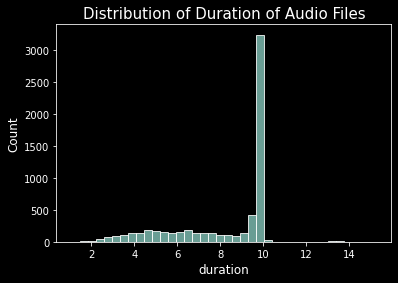

In [ ]:
sns.histplot(duration_df, x='duration')
plt.title('Distribution of Duration of Audio Files');

In [ ]:
duration_df['duration'].describe()

count    6165.000000
mean        8.228697
std         2.307223
min         1.080000
25%         6.480000
50%         9.720000
75%         9.900000
max        15.240000
Name: duration, dtype: float64

In [ ]:
# The 99th percentile in terms of duration is 10.02 seconds
duration_df.quantile(0.99)

Unnamed: 0    6102.36
duration        10.02
Name: 0.99, dtype: float64

In [ ]:
# There are 50 audio files that are greater than 10.02 seconds
len(duration_df[duration_df['duration'] > 10.02])

50

In [ ]:
# If we were to set a filter that did not use audio files greater than 10.02, 
# we would be removing 0.8% of our targeted data
print(f"{round((50/6165) * 100, 2)}%")

0.81%


### Converting .webm audio to .ogg audio

webm files are actually video files. In order for us to be able to extract the audio from these files, we need to find a library that can help us do so.

---



Creating new ogg audio files

In [ ]:
# root_dir = '/cv_audio/neg/'
# new_dir = '/cleaned_audio/neg/'

# os.makedirs(new_dir, exist_ok=True)
# for audio in os.listdir(root_dir)[:10]:
#   extension = os.path.splitext(audio)[-1].lower()
#   print(audio)
#   if extension == '.webm':
#     audio_name = os.path.splitext(audio)[0]
#     input = f"ffmpeg -i {root_dir + audio_name}.webm {new_dir + audio_name}.ogg"
#     os.system(input)
#   else:
#     shutil.copy(src=root_dir + audio, dst=new_dir)

    

In [ ]:
# Defining our current directories for positive and negative files and 
# Creating new directories to store the converted positive and negative files
root_dir_neg = '/cv_audio/neg/'
new_dir_neg = '/cleaned_audio/neg/'
root_dir_pos = '/cv_audio/pos/'
new_dir_pos = '/cleaned_audio/pos/'

def convert_audio(root_dir, new_dir):
  """
  Definition:
  For every item in the root directory, this func identifies the type of audio 
  file. If the audio file is a .webm file, the function uses the library ffmpeg
  to change the file type into an .ogg file and transfers that new file into 
  the new specified directory.

  Args:
  root_dir: Required. Declare the directory that holds the targeted files you wish
  to convert.
  new_dir: Required. Declare the new directory you wish to store the converted
  files. Does not have to exist beforehand.

  Returns:
  Creates the new directory, stores the converted files, and prints the amount 
  of time it took to run the function.
  """
  start = time.time()

  os.makedirs(new_dir, exist_ok=True)
  for audio in os.listdir(root_dir):
    extension = os.path.splitext(audio)[-1].lower()
    if extension == '.webm':
      audio_name = os.path.splitext(audio)[0]
      input = f"ffmpeg -i {root_dir + audio_name}.webm {new_dir + audio_name}.ogg"
      os.system(input)
    else:
      shutil.copy(src=root_dir+audio, dst=new_dir)

  end = time.time()
  time_count(start, end)    

Converting all webm audio files into ogg files

In [ ]:
# Converting any webm files in the '/cv_audio/pos/' directory into ogg files
# and moving all files into a new directory
root_dir_pos = '/cv_audio/pos/'
new_dir_pos = '/cleaned_audio/pos/'

convert_audio(root_dir_pos, new_dir_pos)

Time to run cell: 196 seconds


In [ ]:
# Confirming that the amount of audio files is the same in the new directory
# as the old directory 
len(os.listdir(root_dir_pos)) == len(os.listdir(new_dir_pos))

True

In [ ]:
# Converting any webm files in the '/cv_audio/neg/' directory into ogg files
# and moving all files into a new directory
root_dir_neg = '/cv_audio/neg/'
new_dir_neg = '/cleaned_audio/neg/'

convert_audio(root_dir_neg, new_dir_neg)

Time to run cell: 1955 seconds


In [ ]:
# Confirming that the amount of audio files is the same in the new directory
# as the old directory 
len(os.listdir(root_dir_neg)) == len(os.listdir(new_dir_neg))

True

In [ ]:
run=0
if run:
  shutil.copytree('/cleaned_audio/', 
                '/content/drive/MyDrive/gdrive/capstone/audio_folders/cleaned_audio/')

'/content/drive/MyDrive/gdrive/capstone/audio_folders/cleaned_audio/'

In [ ]:
new_rd = '/content/drive/MyDrive/gdrive/capstone/audio_folders/cleaned_audio/'
for folder in os.listdir(new_rd):
  print(len(os.listdir(new_rd + folder)))

539
5626


In [ ]:
# Checking out an example from our permanent directory
signal, sr = librosa.load('/cleaned_audio/pos/015576c8-2b03-4dcb-b251-78a984fe86fe.ogg')
ipd.Audio(signal, rate=sr)

In [ ]:
def get_audio_duration(root_dir):
  """
  Definition:
  Finds the duration of each audio file in a folder, uses the librosa library to
  get the time duration for each file, and appends each duration to a list called 
  duration_list. This list is then transformed into a dataframe, and then returned
  and the function output.

  Args:
  root_dir: Required. Specify the folder that holds the audio files.

  Returns:
  A dataframe that holds the duration for each audio file and prints the amount
  of time it took to run the function.
  """
  
  duration_list = []
  start = time.time()
  for item in os.listdir(root_dir):
    try:
      # loading the item using librosa if it can load
      y, sr = librosa.load(root_dir + item)
      # setting the variable audio_time and giving it the duration of the file
      audio_time = librosa.get_duration(y, sr)
      # appending the audio_time variable to our list
      duration_list.append(audio_time)
    except:
      # Adding 0 if we can't extract the duration. We should not get any zeros
      duration_list.append(0)

  df = pd.Series(duration_list, name='duration').to_frame()

  end = time.time()
  time_count(start, end)
  return df

In [ ]:
#cleaned_duration_df = get_audio_duration('/cleaned_audio/')

In [ ]:
#cleaned_duration_df['duration'].describe()

count    539.000000
mean       8.407524
std        2.324254
min        1.094694
25%        7.066599
50%        9.781361
75%        9.857370
max       13.089342
Name: duration, dtype: float64

Here we can see that the duration for all our our audio in the '/cleaned_audio/pos/' folder is not uniform. Just like images, we need to feed the model the same shape for audio files as well. To do this, we must add silence to audio files that are less than 10.02 seconds (our 99th percentile) and make them all 10.02 seconds long. After that, we may then proceed to make spectrogram images from each audio file once they are all the correct length. 

### Adding Silent length to Cleaned CV audio

Adding silent length to our audio files less than our max_duration (defined below) in the '/cleaned_audio/pos' folder

In [ ]:
# This cell works correctly, attempting to make a function out of it

start = time.time()

# Setting a limit for maximum duration - this is our 99th percentile
max_duration = 10.02
# Defining our target folder to pull audio from
clean_rd = '/cleaned_audio/pos/'

for audio in os.listdir(clean_rd):
  address = clean_rd + audio
  sig, sr = librosa.load(address)
  dur = librosa.get_duration(sig, sr=sr)
  if dur <= max_duration: 
    # Defining the amount of silence for each audio file
    silent_length = (10.02*1000) - (dur*1000)
    silent_int = int(silent_length)

    # creating 8.4 secs of audio silence -- duration in milliseconds
    silent_segment = AudioSegment.silent(duration=silent_int)

    #read our target wav file example to an audio segment
    cough_audio = AudioSegment.from_ogg(address)

    # Combining our silent segment with the audio example
    extended_cough = cough_audio + silent_segment

    # making a folder to hold our extended audio example
    os.makedirs('/ext_audio/pos/', exist_ok=True)
    output = f'/ext_audio/pos/{audio}' 
    #print(f"{output}\n")
    extended_cough.export(out_f=output)
  else: 
    continue

end = time.time()
time_count(start, end)

Time to run cell: 921 seconds


In [ ]:
def create_silence(root_dir, new_dir, max_dur=10.02):
  """
  Definition:
  Adds silence to each audio file in the specified root directory if the audio 
  file is shorter in length (in seconds) than the 'max_dur' variable. The extended
  audio files are then saved in the 'new_dir' address.

  Args:
  root_dir: Required. The directory that holds the audio files.
  new_dir: Required. The location the extended audio files will be saved to.
  max_dur: default = 10.02. The maximum duration for the audio files to be. If an
  audio file is longer than the maximum duration, the audio file will be skipped
  and not saved into the new directory.

  Returns:
  Saves the extended audio files to the new directory. Prints the time it took 
  to run the function.
  """
  
  start = time.time()

  for audio in os.listdir(root_dir):
    address = root_dir + audio
    sig, sr = librosa.load(address)
    dur = librosa.get_duration(sig, sr=sr)
    if dur <= max_dur: 
      # Defining the amount of silence for each audio file
      silent_length = (max_dur*1000) - (dur*1000)
      silent_int = int(silent_length)

      # creating 8.4 secs of audio silence -- duration in milliseconds
      silent_segment = AudioSegment.silent(duration=silent_int)

      # Finding the extension for each file
      extension = os.path.splitext(audio)[-1].lower()

      if extension == '.mp3':
        cough_audio = AudioSegment.from_mp3(address)

      elif extension == '.ogg':
        cough_audio = AudioSegment.from_ogg(address)

      # Combining our silent segment with the audio example
      extended_cough = cough_audio + silent_segment

      # making a folder to hold our extended audio example
      os.makedirs(new_dir, exist_ok=True)
      output = f'{new_dir + audio}' 
      #print(f"{output}\n")
      extended_cough.export(out_f=output)
    else: 
      continue

  end = time.time()
  time_count(start, end)

### Extending length of virufy audio

Extending all audio in virufy 'pos/' subfolder

In [ ]:
# Testing on virufy data
create_silence(root_dir='/virufy_data-main/clinical/segmented/pos/', 
               new_dir='/ext_audio_virufy/pos/')

Time to run cell: 47 seconds


In [ ]:
virufy_pos_df = get_audio_duration('/ext_audio_virufy/pos/')
virufy_pos_df['duration'].describe()

Time to run cell: 42 seconds


count    48.000000
mean     10.019770
std       0.000024
min      10.019728
25%      10.019773
50%      10.019773
75%      10.019773
max      10.019819
Name: duration, dtype: float64

Extending all audio in virufy 'neg/' subfolder

In [ ]:
create_silence(root_dir='/virufy_data-main/clinical/segmented/neg/', 
               new_dir='/ext_audio_virufy/neg/')

Time to run cell: 71 seconds


In [ ]:
virufy_neg_df = get_audio_duration('/ext_audio_virufy/neg/')
virufy_neg_df['duration'].describe()

Time to run cell: 64 seconds


count    73.000000
mean     10.019769
std       0.000023
min      10.019728
25%      10.019773
50%      10.019773
75%      10.019773
max      10.019819
Name: duration, dtype: float64

 Creating new silenced audio files from our '/cleaned_audio/neg' folder!


In [ ]:
# Sending extended audio to our new_dir
create_silence(root_dir='/cleaned_audio/neg/', new_dir='/ext_audio/neg/')

Time to run cell: 7730 seconds


In [ ]:
# Checking the number of files in our folder
len(os.listdir('/ext_audio/neg/'))

5551

In [ ]:
# Sending extended audio to our new_dir
create_silence(root_dir='/cleaned_audio/pos/', new_dir='/ext_audio/pos/')

Time to run cell: 747 seconds


In [ ]:
len(os.listdir('/ext_audio/pos/'))

533

In [ ]:
# Identifying the number of extended audio files we have so far
len(os.listdir('/ext_audio/neg/')) + len(os.listdir('/ext_audio/pos/'))

6084

In [ ]:
# Copying all of our created files so we don't have to take 3 hours to create 
# them again. Note that these files are only the files from our coughvid dataset, 
# We have not combined the virufy audio data yet.
run = 0
if run: 
  shutil.copytree('/ext_audio/', 
                '/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/')

In [ ]:
# Checking the duration in our negative audio files that we've saved
neg_dur_df = get_audio_duration('/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/neg/')

Time to run cell: 7651 seconds


In [ ]:
(len(os.listdir('/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/neg')) + 
len(os.listdir('/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/pos')))

6084

### Combining our virufy extended audio to our coughvid audio

In [ ]:
virufy_base = '/ext_audio_virufy/'
for folder in os.listdir(virufy_base):
  print(len(os.listdir(virufy_base + folder)))

73
48


In [ ]:
# This is the number we expect to see in our saved audio files after combining
# the datasets
expected_number_files = 6084 + 73 + 48

6205

In [ ]:
# Joining virufy audio with coughvid audio in our permanent folder
run=0
if run:
  virufy_base = '/ext_audio_virufy/'
  new_base = '/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/'

  for folder in os.listdir(virufy_base):
    virufy_address = virufy_base + folder + '/'
    new_address = new_base + folder + '/'

    for audio in os.listdir(virufy_address):
      audio_file = virufy_address + audio
      shutil.move(audio_file, new_address)

In [ ]:
(len(os.listdir('/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/neg')) + 
len(os.listdir('/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/pos')))

6205

Inspecting the newly extended audio

In [ ]:
# Negative audio example
neg_root_dir = '/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/neg/'
audio_ext_ex = os.listdir(neg_root_dir)[0]

neg_signal, sr = librosa.load(neg_root_dir + audio_ext_ex)

### Creating and saving mel-spectrograms

In [ ]:
def create_save_spectros(root_dir, new_dir, hop_length, n_fft, sr=22050,
                         fmax=9000, ref=1, figsize=(10, 4), cmap='magma', 
                         dpi=400, vmin=None, vmax=None):
  """
  Definition:
  Takes the address defined by the variable 'root_dir' and goes through each class
  folder within that directory. For each audio file in a class directory, the 
  librosa library loads the audio file into signal and sample rate variables, then 
  plots the mel-spectrogram. We then save the spectrogram into the address of the 
  'new_dir' folder using the same end name of the audio's original address, and 
  shuts down the figure.

  Args:
  root_dir: Required. The address containing subfolders of classes and audio 
  files within those folders.
  new_dir: Required. The address you wish to save the mel-spectrograms.
  hop_length: Required. The number of samples between successive frames - 
  (e.g. the columns of a spectrogram)
  n_fft: Required. The (positive integer) number of samples in an analysis 
  window (or frame). Should be larger than hop_length.
  sr: default = 22050. The (positive integer) number of samples per second of a 
  time series.
  fmax: default = 9000. Highest frequency (in Hz).
  ref: default = 1. If scalar, the amplitude abs(S) is scaled relative to 'ref'.
  figsize: default = (10, 4). The size of the plotted spectrogram.
  cmap: default = 'magma'. The color palette of the spectrogram.
  dpi: default = 400. The resolution in dots per inch - higher values result in
  higher quality images.

  Returns:
  The time it took to run the function in seconds.
  """
  start = time.time()
  #making sure we add a forward slash to our root_dir and new_dir variables
  if root_dir[-1] != '/':
    root_dir = root_dir + '/'
  if new_dir[-1] != '/':
    new_dir = new_dir + '/'

  # For each subfolder in our root directory:
  for status in os.listdir(root_dir):
    #print(status)

    # Create a new variable called subfolder
    subfolder = root_dir + status
    #print(subfolder)

    # For each audio file in our subfolder, load into signal and sample rate vars
    for audiofile in os.listdir(subfolder):
      signal, sr = librosa.load(subfolder + '/' + audiofile, sr=sr)

      plt.interactive(False)

      # Creating a melspectrogram
      if (vmin != None) and (vmax != None):
        mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, 
                                                    hop_length=hop_length, 
                                                    n_fft=n_fft, fmax=fmax, 
                                                    vmin=vmin, vmax=vmax)
      

      else:
        mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, 
                                                    hop_length=hop_length, 
                                                    n_fft=n_fft, fmax=fmax)
        
      # Converting the power in the ndarray of our mel_signal into decibels
      power_to_db = librosa.power_to_db(mel_signal, ref=ref)
      # Creating figure
      fig = plt.figure(figsize=figsize)
      ax = fig.add_subplot(111)
      # Hiding axes and image frame
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)
      ax.set_frame_on(False)

      # Displaying our spectrograms
      ldp.specshow(power_to_db, sr=sr, cmap=cmap, hop_length=hop_length)
      
      # making folder to store images
      new_subfolder = new_dir + status + '/'
      os.makedirs(new_subfolder, exist_ok=True)

      #print(new_subfolder)

      # Saving each spectrogram into its respective folder
      # subfile[:-4] is a string of the subfile without the ending extension '.mp3'
      # We add the '.png' extension to the end of our new spectrogram images instead
      plt.savefig(fname=new_subfolder + audiofile[:-4] + '.png', dpi=dpi, 
                  bbox_inches='tight',pad_inches=0)
      
      # We then manually close pyplot, clear the figure, close the fig variable, 
      # and then close the figure window
      plt.close()    
      fig.clf()
      plt.close(fig)
      plt.close('all')

  # Display the time it took to run the cell in seconds
  end = time.time()
  time_count(start, end)

Creating our extended audio spectrograms:

In [ ]:
run=0
if run:
  audio_dir = '/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/'
  spec_dir = '/content/drive/MyDrive/gdrive/capstone/spectrograms/'

  create_save_spectros(root_dir=audio_dir, new_dir=spec_dir, hop_length=512, 
                      n_fft=2048, fmax=9000, ref=np.max, figsize=(10, 4))

Time to run cell: 20298 seconds


Saved image shape: (1208, 3100)


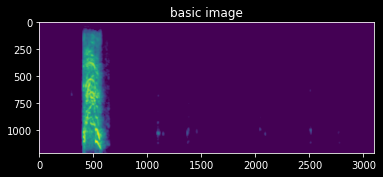

In [ ]:
# Viewing a saved spectrogram and it's dimensions
spec_root = '/content/drive/MyDrive/gdrive/capstone/spectrograms/pos/'
spec_ex = os.listdir('/content/drive/MyDrive/gdrive/capstone/spectrograms/pos/')[0]
img = cv2.imread(spec_root + spec_ex, 0)

print(f"Saved image shape: {img.shape}")
plt.title('basic image')
plt.imshow(img);

(200, 500, 3)


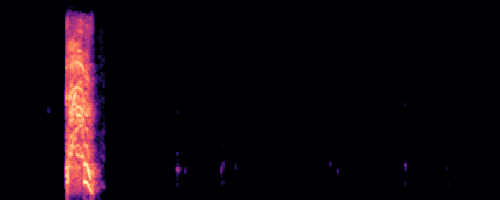

In [ ]:
# Note that we can change the size of our images by using the load_img() function
img_ex = load_img(spec_root + spec_ex, target_size=(200, 500))
print(img_to_array(img_ex).shape)
img_ex

In [ ]:
# Viewing number of spectrograms in our permanent folder
spectro_images = num_items('/content/drive/MyDrive/gdrive/capstone/spectrograms', 
                           targets=['/pos', '/neg'])

/content/drive/MyDrive/gdrive/capstone/spectrograms
Number of items in /pos: 581
Number of items in /neg: 5624
Total number of items: 6205


Adjusting our Spectro images and creating a new folder of spectrograms w/ a sample rate of 48,000. Instead of using our permanent folder location as our directory when creating the images, we will make a copy of the folder and place it in the root directory so it is easier toa access which should speed up the time it takes to create the spectrograms.

In [ ]:
# Copying the saved directory containing the extended audio we used to create
# the spectrograms
shutil.copytree('/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/', 
                '/ext_audio_temp/')

'/ext_audio_temp/'

In [ ]:
# Viewing the number of items in our temporary folder
num_items('/ext_audio_temp', targets=['/pos', '/neg'])

/ext_audio_temp
Number of items in /pos: 581
Number of items in /neg: 5624
Total number of items: 6205


6205

In [ ]:
# Creating the 48k sample rate spectrograms and placing them in a new folder
# /spectros_48k_sr/
run=0
if run:
  audio_dir = '/ext_audio_temp/'
  spec_dir = '/spectros_48k_sr/'

  create_save_spectros(root_dir=audio_dir, new_dir=spec_dir, hop_length=128, 
                       n_fft=1024, fmax=9000, ref=np.max, figsize=(10, 4), 
                       sr=48000, dpi=300)

Time to run cell: 9956 seconds


In [ ]:
# Saving our new 48k sample rate spectrograms into a permanent folder so we 
# don't need to run the above cell everytime.
shutil.copytree('/ext_audio_temp/', '/content/drive/MyDrive/gdrive/capstone/audio_folders/spectros_48k_sr/')

'/content/drive/MyDrive/gdrive/capstone/audio_folders/spectros_48k_sr/'

### Test Area: Reducing Audio Length

We are going to create another group of preprocessed audio data. However, instead of making the audio files the length of 10 seconds, we are going to use librosa.effects.trim() function to remove any silence before and after the audio in each file. This way, we will effectively reduce the legnth of the files, and hopefully reduce the 99th percentile which will create better images for our model.

In [ ]:
def reduce_audio_length(root_dir, new_dir):
  """
  Definition:
  Removes any silence at the start and end of each audio file in the specified 
  root directory if the audio. The reduced audio files are then saved in the 
  'new_dir' address.

  Args:
  root_dir: Required. The directory that holds the audio files.
  new_dir: Required. The location the extended audio files will be saved to.

  Returns:
  Saves the reduced audio files to the new directory. Prints the time it took 
  to run the function.
  """
  start = time.time()
  if root_dir[-1] != '/':
    root_dir = root_dir +'/'
  if new_dir[-1] != '/':
    new_dir = new_dir + '/'

  for status in os.listdir(root_dir):
    # making the file address
    address = root_dir + status + '/'
    os.makedirs(new_dir + status, exist_ok=True)
    for audio_file in os.listdir(address):
      # creating a tag to fit into the write_wav() function
      tag = audio_file.split('/')[-1][:-4]
      
      #loading the signal and sr for the audio file
      signal, sr = librosa.load(address + audio_file, sr=22050)

      # trimming the signal and storing it in a new variable, 'trimmed_sig'
      trimmed_sig, index = librosa.effects.trim(signal)

      # Saving our trimmed signal to the new directory
      librosa.output.write_wav(path=new_dir + status + '/' + tag + '.wav', 
                               y=trimmed_sig, sr=sr)
      
    print(f'Finished with {status}')
  end = time.time()
  time_count(start, end)

In [ ]:
# Reducing the audio length of our virufy audio data
reduce_audio_length('/virufy_data-main/clinical/segmented', '/virufy_reduced/')

Finished with pos
Finished with neg
Time to run cell: 83 seconds


In [ ]:
num_items('/virufy_reduced/', ['pos/', 'neg/'])

/virufy_reduced/
Number of items in pos/: 48
Number of items in neg/: 73
Total number of items: 121


121

In [ ]:
# Reducing the audio length of our CoughVid audio data
reduce_audio_length('/cleaned_audio/', new_dir='/cleaned_reduced_audio/')

Finished with pos
Finished with neg
Time to run cell: 6671 seconds


In [ ]:
num_items('/cleaned_reduced_audio/', ['pos/', 'neg/'])

/cleaned_reduced_audio/
Number of items in pos/: 539
Number of items in neg/: 5626
Total number of items: 6165


6165

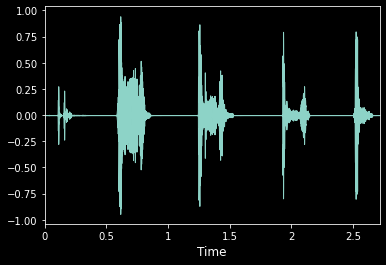

In [ ]:
# Viewing an example audio file
signal, sr = librosa.load('/cleaned_reduced_audio/pos/015576c8-2b03-4dcb-b251-78a984fe86fe.wav')
ldp.waveplot(signal, sr)

In [ ]:
# Copying our virufy audio data and joining it with our coughvid data
run=0
if run:
  virufy_base = '/virufy_reduced/'
  new_base = '/cleaned_reduced_audio/'

  for status in os.listdir(virufy_base):
    virufy_address = virufy_base + status + '/'
    new_address = new_base + status + '/'

    for audio in os.listdir(virufy_address):
      audio_file = virufy_address + audio
      shutil.move(audio_file, new_address)

In [ ]:
num_items('cleaned_reduced_audio/', ['pos/', 'neg/'])

cleaned_reduced_audio/
Number of items in pos/: 587
Number of items in neg/: 5699
Total number of items: 6286


6286

In [ ]:
# Moving a copy of our reduced audio to our google drive
run=0
if run:
  shutil.copytree('/cleaned_reduced_audio/', 
                  '/content/drive/MyDrive/gdrive/capstone/audio_folders/cleaned_reduced_audio/')

In [ ]:
# Checking to make sure our number of items is the same as the copied tree
num_items('/content/drive/MyDrive/gdrive/capstone/audio_folders/cleaned_reduced_audio/', ['pos/', 'neg/'])

/content/drive/MyDrive/gdrive/capstone/audio_folders/cleaned_reduced_audio/
Number of items in pos/: 587
Number of items in neg/: 5699
Total number of items: 6286


6286

In [ ]:
# Improving our get_audio_duration() function

def get_audio_duration(root_dir):
  """
  Definition:
  Finds the duration of each audio file in a folder, uses the librosa library to
  get the time duration for each file, and appends each duration to a list called 
  duration_list. This list is then transformed into a dataframe, and then returned
  and the function output.

  Args:
  root_dir: Required. Specify the folder that holds the audio files.

  Returns:
  A dataframe that holds the duration for each audio file and prints the amount
  of time it took to run the function.
  """
  
  duration_list = []
  start = time.time()
  if root_dir[-1] != '/':
    root_dir = root_dir + '/'
  for status in os.listdir(root_dir):
    address = root_dir + status + '/'
    for audiofile in os.listdir(address):
      try:
        # setting the variable audio_time and giving it the duration of the file
        audio_time = librosa.get_duration(filename=address+audiofile)
        # appending the audio_time variable to our list
        duration_list.append(audio_time)
      except:
        # Adding 0 if we can't extract the duration. We should not get any zeros
        duration_list.append(0)

  df = pd.Series(duration_list, name='duration').to_frame()

  end = time.time()
  time_count(start, end)
  return df

In [ ]:
# Only need to run this once. We will save the dataframe in a permanent folder
# once it is created.

#reduced_df = get_audio_duration('/cleaned_reduced_audio/')

Time to run cell: 3758 seconds


In [ ]:
# Saving the dataframe

#reduced_df.to_csv('/content/drive/MyDrive/gdrive/capstone/created_dfs/reduced_duration.csv')

In [ ]:
reduced_duration_df = pd.read_csv('/content/drive/MyDrive/gdrive/capstone/created_dfs/reduced_duration.csv')

In [ ]:
reduced_duration_df['duration'].describe()

count    6286.000000
mean        6.437051
std         2.666110
min         0.300000
25%         4.300000
50%         6.800000
75%         8.900000
max        14.900000
Name: duration, dtype: float64

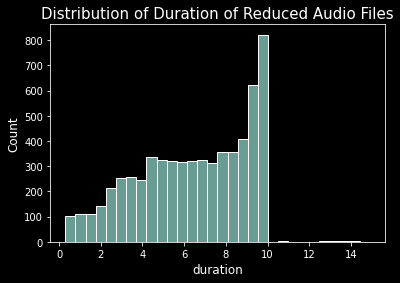

In [ ]:
sns.histplot(reduced_duration_df, x='duration')
plt.title('Distribution of Duration of Reduced Audio Files');

In [ ]:
reduced_duration_df['duration'].quantile(.99)

9.9

Unfortunately, the 99% percentile of this audio data is 9.9 seconds, whereas the untrimmed audio files that we worked with before was approximately 10.02 seconds. This means that we only managed to shave off 0.12 seconds of the 99th percentile for the data. 

## Preparing Image Data Generators

### Creating train, test, and val folders

In [ ]:
# Splitting our spectrogram images into train, test, and validation subfolders
# and saving these folders in our google drive so we can access them after we shut
# down our runtime

# We only want to run this once, so we set a variable called run to 0 to prevent
# it from running again by accident.
run = 0
base_folder = '/content/drive/MyDrive/gdrive/capstone/spectrograms'
if run:
  splitfolders.ratio(input=base_folder, 
                    output='/content/drive/MyDrive/gdrive/capstone/spectro_folders', 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio order: train, val, test
else:
  print('Did not run')

Did not run


Using the zipped spectro_folders_zip file from here on to work with. Once we've run the above code, we manually zip the file outside google colab. We then bring it back in to unzip the folder. Google colab is able to access more quickly the data from a zipped folder when compared to an unzipped folder - which is saving us time.

In [ ]:
# Unzipping our zipped spectro folder and moving it to the root directory for
# easier access
f_name = '/content/drive/MyDrive/gdrive/capstone/spectro_folders_zip.zip'
with ZipFile(f_name, 'r') as zipf:
      zipf.extractall()
      print('Done')

Done


In [ ]:
# Checking to make sure we still have the same number of images
spectro_root_dir = '/spectro_folders'
folder_check(spectro_root_dir, check=0)

/spectro_folders/train/
Number of items in neg: 3936
Number of items in pos: 406
Total number of items: 4342

/spectro_folders/test/
Number of items in neg: 1126
Number of items in pos: 118
Total number of items: 1244

/spectro_folders/val/
Number of items in neg: 562
Number of items in pos: 57
Total number of items: 619


Total image count: 6205


In [ ]:
# Creating train, test, and validation folders
train_folder, test_folder, val_folder = create_ttv(spectro_root_dir)

In [ ]:
train_folder

'/spectro_folders/train/'

In [ ]:
# Setting batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (200,500)

In [ ]:
# Creating image data generators and iterators to allow our folders to flow through
aug_spectro_datagen = ImageDataGenerator(rescale=1./255, 
                                         width_shift_range=0.1, 
                                         brightness_range=(0.9, 1.3), 
                                         zoom_range=0.1)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_spectro_gen = aug_spectro_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='binary')

test_spectro_gen = test_val_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='binary')

val_spectro_gen = test_val_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')

Found 4342 images belonging to 2 classes.
Found 1244 images belonging to 2 classes.
Found 619 images belonging to 2 classes.


In [ ]:
# Viewing classes
train_spectro_gen.class_indices

{'neg': 0, 'pos': 1}

In [ ]:
# Viewing the shape
train_spectro_gen.image_shape

(200, 500, 3)

In [ ]:
# Viewing the spectrograms image shape
INPUT_SHAPE = train_spectro_gen.image_shape
print(INPUT_SHAPE)

(200, 500, 3)


In [ ]:
# Our classes are extremely unbalanced
class_weights_dict = make_class_weights(train_spectro_gen)

{0: 0.5515752032520326, 1: 5.347290640394089}


### Creating a basic model for spectrograms

In [ ]:
def spectro_model(shape='', opt=tf.keras.optimizers.Adam(), 
                        metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall'), 
                                        tf.keras.metrics.AUC(name='auc')],
                        loss=tfa.losses.SigmoidFocalCrossEntropy(), 
                        verbose=1):
  """
  Definition:
  Creates and compiles a neural network model. 

  Args:
  shape: default = ''. The input shape of the images to be passed in to the 
  neural network. The size must be the same as the images being passed in.
  metrics: default = ['acc', tf.keras.metrics.Precision(name='precision'),
                             tf.keras.metrics.Recall(name='recall'), 
                             tf.keras.metrics.AUC(name='auc')].
           The metrics that are to be analyzed and plotted from the 
           training of the model. 
  loss: default = tfa.losses.SigmoidFocalCrossEntropy(). The loss metric used when
  the model is compiled.
  verbose: default = 1. If 1, prints a summary of the model upon compilation.

  Returns:
  The model, along with the model.summary() if verbose = 1.
  """
  if len(shape) < 1:
    print('Please define input shape!')
  else:
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=shape))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(256, activation='relu'))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    print(model.summary())
    return model

In [ ]:
def leaky_spectro_model(shape='', opt=tf.keras.optimizers.Adam(), alpha=0.2,
                          metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall'), 
                                        tf.keras.metrics.AUC(name='auc')],
                        loss=tfa.losses.SigmoidFocalCrossEntropy(), verbose=1):
  """
  Definition:
  Creates and compiles a neural network model. Utilizes leaky ReLU instead of relu
  and the activation layer.

  Args:
  shape: default = ''. The input shape of the images to be passed in to the 
  neural network. The size must be the same as the images being passed in.
  metrics: default = ['acc', tf.keras.metrics.Precision(name='precision'),
                             tf.keras.metrics.Recall(name='recall'), 
                             tf.keras.metrics.AUC(name='auc')].
           The metrics that are to be analyzed and plotted from the 
           training of the model. 
  loss: default = tfa.losses.SigmoidFocalCrossEntropy(). The loss metric used when
  the model is compiled.
  verbose: default = 1. If 1, prints a summary of the model upon compilation.

  Returns:
  The model, along with the model.summary() if verbose = 1.
  """

  if len(shape) < 1:
    print('Please define input shape!')
  else:
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), input_shape=shape))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3,3)))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (5, 5)))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(MaxPooling2D((4, 4)))

    model.add(layers.Conv2D(256, (3, 3)))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    if verbose:
      print(model.summary())
    return model

In [ ]:
spectro_model1 = spectro_model(shape=INPUT_SHAPE)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 498, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 249, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 247, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 123, 64)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 121, 128)      73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 60, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 58, 256)      

136/136 [==============================] - 435s 3s/step - loss: 0.0734 - acc: 0.9065 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4843 - val_loss: 0.0699 - val_acc: 0.9079 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5238
---------------------------------------------------------
                  Classification Report

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1126
           1       0.00      0.00      0.00       118

    accuracy                           0.91      1244
   macro avg       0.45      0.50      0.48      1244
weighted avg       0.82      0.91      0.86      1244

---------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


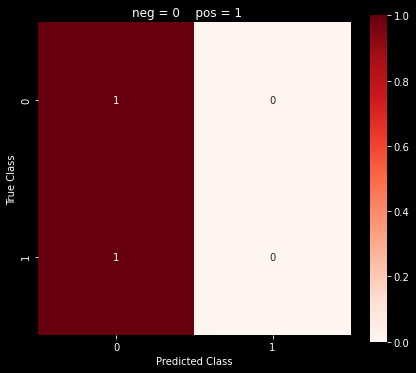

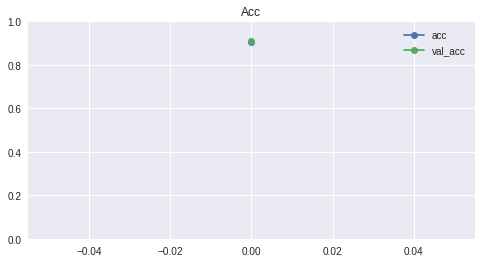

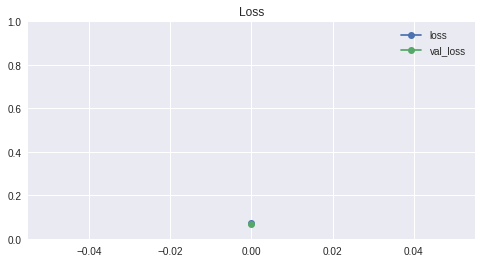

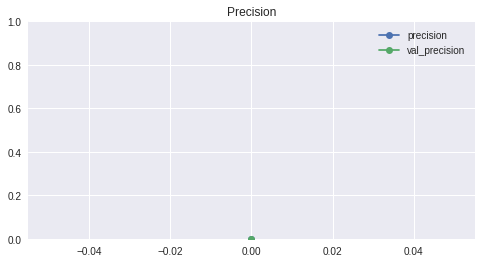

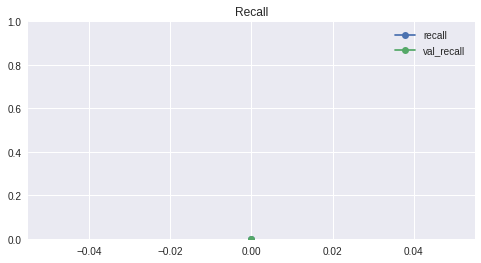

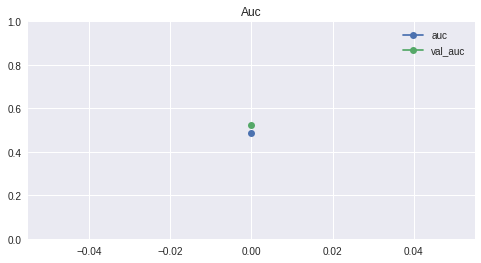

------------------------------------------------------------
39/39 [==============================] - 80s 2s/step - loss: 0.0698 - acc: 0.9051 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5466
loss score: 0.06984978169202805
accuracy score: 0.9051446914672852
precision score: 0.0
recall score: 0.0
auc score: 0.5465574860572815

Time to run cell: 603 seconds


In [ ]:
spectro_fpr = fit_plot_report_gen(spectro_model1, train_spectro_gen, 
                                  test_spectro_gen, val_spectro_gen, epochs=5, 
                                  class_weights=class_weights_dict)

####Possible reasons our model is unable to differentiate between classes:

2. Our model could struggling with identifying the different classes due to the imbalance.
3. The labels that were marked in the coughvid dataset 'status' column were self-reported, so there could be noise in the labels.
4. The model may not be able to find any patterns in the spectrograms we created from the audio files.
5. Our model may not be complex enough to find any patterns in our spectrograms.
6. The silence in audio files may be introducing ambiguity into the models, which could be interfering with our model's accuracy and ability to differentiate between the classes.

The cough data we retrieved is sparse and hard to come by. Considering COVID-19 audio datasets of high quality are rare and many institutions that are working on cleaning their data for their own models have yet to make their data available to the public (such as University of Cambridge, Massachussetts Institute of Technology, NIH, etc.). There are different ways other researchers have gone about using Convolutional Neural Networks with cough audio data. The different types of images that have been created and trained on in other research range from spectrograms, Mel-Frequency cepstral coefficients, and mel-spectrograms why trying to classify the COVID-19 cough audio. 

Considering the time constraint for the capstone project, I won't be able to explore all of these options to the fullest extent. However, I would say these options of exploration could definitely be deemed as further research for this project. As time continues to pass, even more cough audio data may become open to the public.

### Oversampling with Image Augmentation Manipulation

We are going to attempt to address the class imbalance by creating augmented images of the minority class spectrograms and combine these images with our training folder to create a faux balanced dataset.

In [ ]:
# We are going to create augmented images from our training folder's minority
# class and save them into a new directory
train_folder = '/spectro_folders/train/'
train_minority_folder = train_folder + 'pos/'
train_majority_folder = train_folder + 'neg/'

#Viewing the number of images in our majority class of the training folder
print(f"Number of images in majority class: {len(os.listdir(train_majority_folder))}\n"
      f"Number of images in minority class: {len(os.listdir(train_minority_folder))}")

Number of images in majority class: 3936
Number of images in minority class: 406


### Creating a copy of spectro_folder and removing all majority class images

In [ ]:
# copying the train folder
shutil.copytree(train_folder, '/train_copy/')

'/train_copy/'

In [ ]:
# Verifying that the amount of images in the copied folder is the same as the 
# original folder
num_items('/train_copy/', targets=['pos/', 'neg/'])

/train_copy/
Number of items in pos/: 406
Number of items in neg/: 3936
Total number of items: 4342


4342

In [ ]:
# removing all negative images within the copied train folder
shutil.rmtree('/train_copy/neg/')
# recreating the 'neg/' subfolder in our copied train folder
os.makedirs('/train_copy/neg/')

In [ ]:
# Verifying that we have removed all images in the negative folder
num_items('/train_copy/', targets=['pos/', 'neg/'])

/train_copy/
Number of items in pos/: 406
Number of items in neg/: 0
Total number of items: 406


406

#### Minority Data Generator

In [ ]:
# Creating a data generator for the minority class
min_datagen = ImageDataGenerator(rescale=1./255,  
                                 width_shift_range=0.1, 
                                 channel_shift_range=0.2, 
                                 shear_range=0.2, 
                                 brightness_range=[0.75, 1.3])
IMG_SIZE = (200,500)

In [ ]:
aug_train_folder = '/train_copy/'

# Making a directory to store the augmented images
aug_dir = '/aug_images/'
os.makedirs(aug_dir, exist_ok=True)

aug_iter = min_datagen.flow_from_directory(aug_train_folder, 
                                           target_size=IMG_SIZE, 
                                           batch_size=406, 
                                           save_to_dir=aug_dir, 
                                           save_prefix='aug', 
                                           shuffle=True)

Found 406 images belonging to 2 classes.


In [ ]:
print(f"Difference between classes: "
f"{len(os.listdir(train_majority_folder)) - len(os.listdir(train_minority_folder))}")

Difference between classes: 3530


In [ ]:
# Creating 3530 augmentations of our minority class images in our train folder
# Adding these augmentation images to our positive images will balance our classes
start = time.time()

while len(os.listdir('/aug_images/')) < 3530:
  next(aug_iter)

end = time.time()
time_count(start, end)

Time to run cell: 385 seconds


In [ ]:
# Viewing the amount of augmented images we've created so far
len(os.listdir(aug_dir))

3654

In [ ]:
# Removing random augmented image files from our augmented image folder so the 
# classes will be equal

while len(os.listdir(aug_dir)) > 3530:
  rand_chosen = np.random.choice(os.listdir(aug_dir))
 
  random_path = aug_dir + rand_chosen
  try:
    os.remove(random_path)
  except:
    continue


In [ ]:
len(os.listdir(aug_dir))

3530

In [ ]:
def display_images(source, amnt_to_display):
  """
  Definition:
  Define the 'source' variable by giving it a filepath containing images along with
  setting the number you wish to view through the variable 'amnt_to_display'. The
  function will plot the selected number of images within the file and display them.

  Args:
  source: Required. A filepath containing images.
  amnt_to_display: Required. The number of images you wish to display.

  Returns:
  Plots a certain amount of images from the selected filepath.
  """
  
  plt.figure(figsize=(20,10))
  cols = amnt_to_display//2
  images = os.listdir(source)[:amnt_to_display]
  for i, img in enumerate(images):
      #Opening each image from its respective filepath
      x_image = Im.open(source+img)
      # defining the position for each subplot 
      # subplot(nrows, ncols, index)
      plt.subplot(len(images) / cols + 1, cols, i + 1)
      #plotting each image in a new subplot
      plt.imshow(x_image)
      # Hiding the x and y axis tick marks
      plt.xticks([])
      plt.yticks([])
      # fitting the images closer together
      plt.tight_layout()

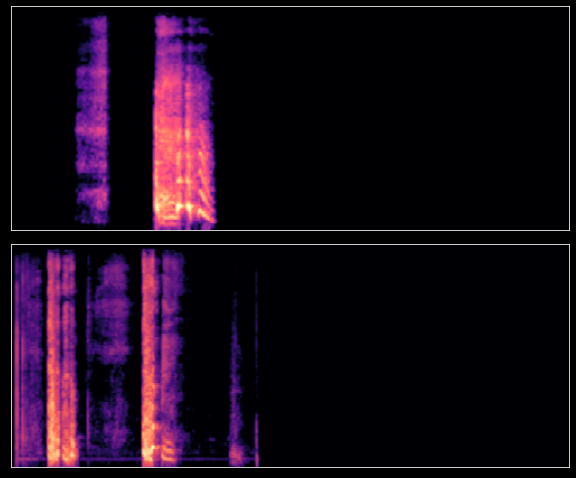

In [ ]:
display_images('/aug_images/', amnt_to_display=2)

In [ ]:
# Making another copy of our spectrogram folder - we will use this one to model
# with. We are going to add our augmentations into the minority class of the 
# training folder
shutil.copytree('/spectro_folders/', '/spectro_modeling/')

'/spectro_modeling/'

In [ ]:
# Viewing the number of images in each class for each subfolder
folder_check('/spectro_modeling')

/spectro_modeling/train/
Number of items in pos: 406
Number of items in neg: 3936
Total number of items: 4342

/spectro_modeling/test/
Number of items in pos: 118
Number of items in neg: 1126
Total number of items: 1244

/spectro_modeling/val/
Number of items in pos: 57
Number of items in neg: 562
Total number of items: 619


Total image count: 6205


In [ ]:
# Copying over our augmented images into the training minority class folder ('pos')
for f in os.listdir(aug_dir):
  shutil.copy(aug_dir + f, '/spectro_modeling/train/pos/')

In [ ]:
# Sanity check
folder_check('/spectro_modeling')

/spectro_modeling/train/
Number of items in pos: 3936
Number of items in neg: 3936
Total number of items: 7872

/spectro_modeling/test/
Number of items in pos: 118
Number of items in neg: 1126
Total number of items: 1244

/spectro_modeling/val/
Number of items in pos: 57
Number of items in neg: 562
Total number of items: 619


Total image count: 9735


In [ ]:
# Creating strings to define the address for each train, test, and val folder
train_spec, test_spec, val_spec = create_ttv('/spectro_modeling')

In [ ]:
# Setting batch size and image size
#train_batch, test_batch, val_batch = batch_sizes([train_spec, test_spec, val_spec])
IMG_SIZE = (200, 500)

In [ ]:
# Rescaling the images to floats based off of the RGB intensity values (0-255)
# This way, the values will be numbers somewhere between 0 and 1.
spec_gen = ImageDataGenerator(rescale=1./255)

# Creating iterators for train, test, and val sets
train_spec_gen = spec_gen.flow_from_directory(train_spec, 
                                              target_size=IMG_SIZE,
                                              batch_size=32,
                                              class_mode='binary', 
                                              shuffle=True)

test_spec_gen = spec_gen.flow_from_directory(test_spec, 
                                             target_size=IMG_SIZE,
                                             batch_size=32,
                                             class_mode='binary', 
                                             shuffle=False)

val_spec_gen = spec_gen.flow_from_directory(val_spec, 
                                            target_size=IMG_SIZE,
                                            batch_size=32,
                                            class_mode='binary', 
                                            shuffle=True)

Found 7872 images belonging to 2 classes.
Found 1244 images belonging to 2 classes.
Found 619 images belonging to 2 classes.


In [ ]:
# Since our class weights should be even, we don't need the class weights for 
# this modeling process
class_weights_dict = make_class_weights(train_spec_gen)

{0: 1.0, 1: 1.0}


In [ ]:
INPUT_SHAPE = train_spec_gen.image_shape
INPUT_SHAPE

(200, 500, 3)

In [ ]:
spectro_model3 = leaky_spectro_model(INPUT_SHAPE, opt=tf.keras.optimizers.Adam(learning_rate=0.001))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 198, 498, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 198, 498, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 99, 249, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 97, 247, 64)       18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 97, 247, 64)       0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 123, 64)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 44, 119, 128)     

Epoch 1/5
246/246 [==============================] - 344s 1s/step - loss: 0.0734 - acc: 0.5522 - precision: 0.7810 - recall: 0.1290 - auc: 0.6588 - val_loss: 0.0687 - val_acc: 0.9063 - val_precision: 0.3333 - val_recall: 0.0175 - val_auc: 0.4796
Epoch 2/5
246/246 [==============================] - 344s 1s/step - loss: 0.0547 - acc: 0.7314 - precision: 0.9295 - recall: 0.4918 - auc: 0.8124 - val_loss: 0.0570 - val_acc: 0.9079 - val_precision: 0.5000 - val_recall: 0.0526 - val_auc: 0.4785
Epoch 3/5
246/246 [==============================] - 346s 1s/step - loss: 0.0634 - acc: 0.7203 - precision: 0.9117 - recall: 0.4895 - auc: 0.8076 - val_loss: 0.0503 - val_acc: 0.8821 - val_precision: 0.1364 - val_recall: 0.0526 - val_auc: 0.5486
Epoch 4/5
246/246 [==============================] - 348s 1s/step - loss: 0.0355 - acc: 0.8497 - precision: 0.9790 - recall: 0.7150 - auc: 0.9064 - val_loss: 0.0309 - val_acc: 0.9079 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4933
Epoch 5/

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


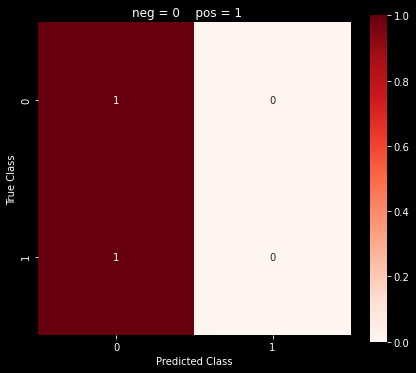

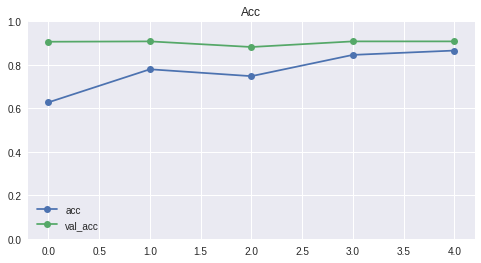

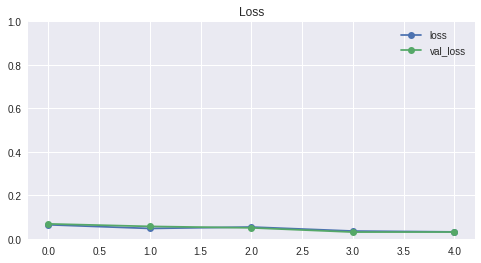

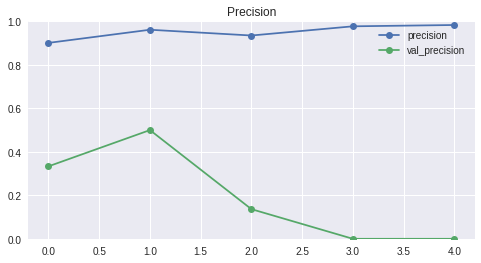

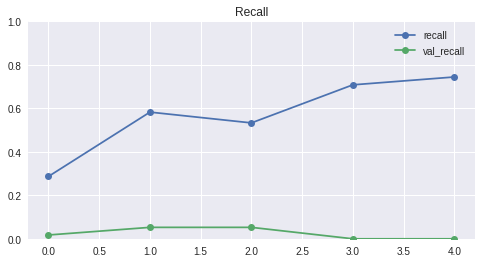

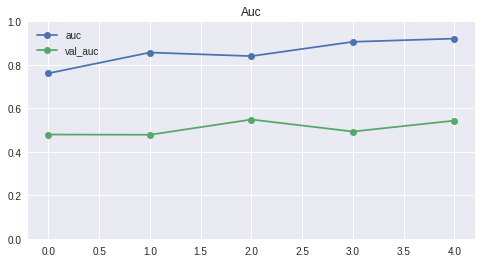

------------------------------------------------------------
39/39 [==============================] - 83s 2s/step - loss: 0.0315 - acc: 0.9051 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5335
loss score: 0.0315004326403141
accuracy score: 0.9051446914672852
precision score: 0.0
recall score: 0.0
auc score: 0.5335294604301453

Time to run cell: 1900 seconds


In [ ]:
spectro_oversamp_fpr = fit_plot_report_gen(spectro_model3, train_spec_gen, test_spec_gen, val_spec_gen, 
                                           epochs=5)

### Unzipping our 48k Sample Rate Spectrograms

In [ ]:
# Unzipping our spectrogram folder that we've slightly changed.
# In this folder, we've created spectograms with a sample rate of 48000 instead 
# of the default 22050.  
f_name = '/content/drive/MyDrive/gdrive/capstone/spectros_48k_sr_zip.zip'
with ZipFile(f_name, 'r') as zipf:
      zipf.extractall()
      print('Done')

Done


In [ ]:
# Creating train, test, val folders 
run = 1
base_folder = '/spectros_48k_sr/'
if run:
  splitfolders.ratio(input=base_folder, 
                    output='/spectros_48k_ttv/', 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio order: train, val, test
else:
  print('Did not run')

Copying files: 6205 files [00:01, 4922.41 files/s]


In [ ]:
spectro48_root_dir = '/spectros_48k_ttv'
folder_check(spectro48_root_dir, check=0)

/spectros_48k_ttv/train/
Number of items in pos: 406
Number of items in neg: 3936
Total number of items: 4342

/spectros_48k_ttv/test/
Number of items in pos: 117
Number of items in neg: 1126
Total number of items: 1243

/spectros_48k_ttv/val/
Number of items in pos: 58
Number of items in neg: 562
Total number of items: 620


Total image count: 6205


In [ ]:
train_48_folder, test_48_folder, val_48_folder = create_ttv(spectro48_root_dir)

In [ ]:
IMG_SIZE = (200, 500)
BATCH_SIZE = 32

aug_48_datagen = ImageDataGenerator(rescale=1./255, 
                                         width_shift_range=0.1, 
                                         brightness_range=(0.9, 1.3), 
                                         zoom_range=0.1)

test_val_48_datagen = ImageDataGenerator(rescale=1./255)

train_48_gen = aug_48_datagen.flow_from_directory(train_48_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='binary')

test_48_gen = test_val_48_datagen.flow_from_directory(test_48_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='binary')

val_48_gen = test_val_48_datagen.flow_from_directory(val_48_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


### Looking at Our 'expert_df' from CoughVid dataframe

In [ ]:
expert_df = pd.read_csv('/content/drive/MyDrive/gdrive/capstone/created_dfs/expert_df.csv')

In [ ]:
expert_df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
expert_df.head()

,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,cough_type_3,diagnosis_3,severity_3
0,002db0bd-e57f-4c30-ade0-16640d424eb7,2020-04-13T19:51:11.397697+00:00,0.9536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,False,False,False,True,unknown,healthy_cough,pseudocough
1,005b8518-03ba-4bf5-86d2-005541442357,2020-04-14T20:16:53.677536+00:00,0.9854,45.2,19.7,23.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,dry,False,False,False,False,False,True,lower_infection,mild,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,006d8d1c-2bf6-46a6-8ef2-1823898a4733,2020-04-22T10:24:21.408615+00:00,0.2677,NaN,NaN,28.0,male,True,True,symptomatic,ok,dry,False,False,False,False,False,True,healthy_cough,pseudocough,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,008ba489-31ad-44d8-856b-fcf72369dc46,2020-04-13T23:09:36.585124+00:00,0.9962,38.1,-122.2,28.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,True,False,False,False,wet,lower_infection,mild
4,008c1c9e-aeef-40c5-846c-24f1b964f884,2020-04-12T21:25:00.131353+00:00,0.9751,48.9,2.7,44.0,male,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,False,False,False,True,wet,healthy_cough,pseudocough


In [ ]:
expert_df['diagnosis_1'].value_counts()

COVID-19               279
healthy_cough          259
lower_infection        244
upper_infection         23
obstructive_disease     15
Name: diagnosis_1, dtype: int64

In [ ]:
exp_covid_df = expert_df[(expert_df['diagnosis_1'] == 'COVID-19') | (expert_df['diagnosis_2'] == 'COVID-19') | (expert_df['diagnosis_3'] == 'COVID-19')]

In [ ]:
exp_covid_df.head()

,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,cough_type_3,diagnosis_3,severity_3
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
102,01567151-7bb2-45ee-9aa8-a1332b5941ea,2020-04-14T15:22:08.514166+00:00,0.9820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,dry,False,False,False,True,False,False,COVID-19,mild,good,dry,True,False,False,False,False,False,COVID-19,mild,good,False,False,False,False,False,False,wet,lower_infection,severe
144,01ff40e8-63e6-4570-a463-9778ea30cad7,2020-04-14T03:27:49.745920+00:00,0.9686,NaN,NaN,24.0,other,False,False,symptomatic,poor,dry,False,False,False,False,False,True,healthy_cough,pseudocough,ok,dry,False,False,False,False,False,True,COVID-19,unknown,good,False,False,False,False,False,True,wet,upper_infection,mild
260,038592cb-c8db-4f55-8052-e20059146cb5,2020-04-13T19:12:13.945215+00:00,0.9824,NaN,NaN,28.0,male,False,False,healthy,ok,dry,False,False,False,False,False,True,COVID-19,mild,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,03d30b8b-03f8-4089-bda8-0e14deec7d82,2020-04-10T02:49:10.601484+00:00,0.9196,-31.4,-58.0,47.0,male,True,False,COVID-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,wet,False,False,True,False,False,False,COVID-19,mild,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519,06e9197b-9b40-4bde-bde8-9e78242a60ac,2020-04-16T09:15:17.509571+00:00,0.9952,NaN,NaN,33.0,female,False,False,symptomatic,ok,dry,False,False,False,False,False,True,COVID-19,mild,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
